# Simulating a model with MaBoSS

In [1]:
%matplotlib inline
import numpy as np
# import seaborn as sns; sns.set()

import ginsim
import biolqm
import maboss
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
import pandas as pd # for the visualization of lists of states
import os
import itertools
import time


In [2]:
from own_functions import *
from MaBoSSTestCase import *
import sys


# Simplified (krasreduced_dnarep_simplif.bnet)

In [3]:
## Load the Wild-Type model
# WT = maboss.load("../../exastolog/model_files/krasreduced_dnarep_simplif.bnd",\
#                 "../../exastolog/model_files/krasreduced_dnarep_simplif.cfg")

# WT=maboss.loadBNet('../../exastolog/model_files/krasreduced_dnarep_simplif.bnet')
WT=maboss.loadBNet('krasreduced_dnarep_simplif_mitot_catast.bnet')

# set max time
WT.param["max_time"]=100

## modify the max_time if necessary
## select the variables considered to be internal (not appearing in the resulting csv file) 
## run the model for random initial conditions (defined in the cfg file) or from all 0s initial conditions 

# WT_allinputs=maboss.copy_and_update_parameters(WT, {'max_time':50})

## By default, all variables are external (in the cfg file: Node.is_internal = FALSE). 
## If the model is big, the computations may take a very long time.
## We advise to set as external, only the variables that are relevant for the analysis

## if you wish to put some values as internal (the ones that will not be used for the analysis), write (uncomment):
# for name in "ERK MK2 p38 BRAF CDK1 TP53".split(' '):
#    WT_allinputs.network[name].is_internal = True
#  Proliferation CASP3

## Select outputs for visualisation of the results
# WT_allinputs.network.set_output(('Proliferation','Senescence','Apoptosis'))
# WT_allinputs.network.set_output(('EGFR','BRAF','CDK1','DNArepair','DSB_SSB','Proliferation','CASP3'))

WT.network.set_istate('EGFR',[0,1]); WT.network.set_istate('DNArepair',[1,0])
WT.network.set_istate('DSB_SSB',[1,0]); WT.network.set_istate('RAS',[1,0])

# set parameter
# WT.param["$d_DSB_SSB"]=0.01

## Run a MaBoSS simulation
run_WT_allinputs=WT.run()

In [425]:
run_WT_allinputs.get_last_nodes_probtraj()

BRAF  CDC25A  CDC25B_C    CDK1   CHEK1    EGFR     MEK  Mitosis  \
99.0000  0.8026  0.1273    0.1273  0.1273  0.8026  0.8026  0.8026   0.1696   

         Proliferation     RAS     p38  
99.0000         0.1696  0.8026  0.8026

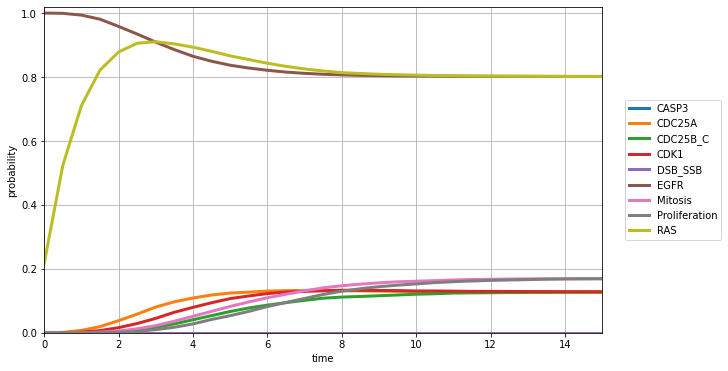

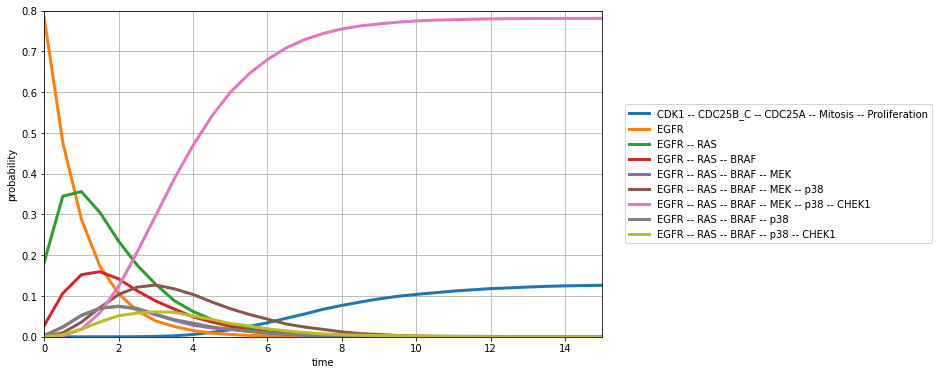

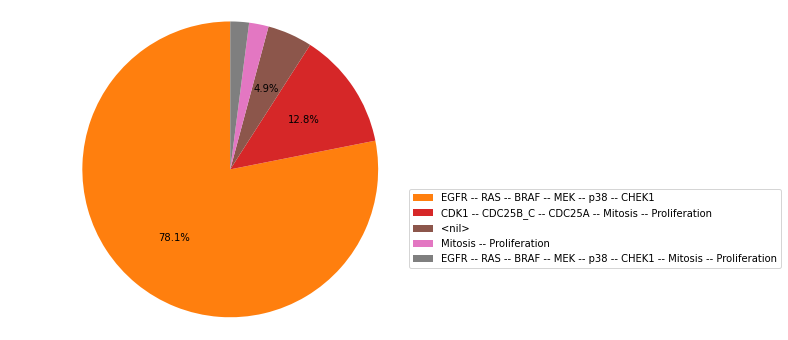

In [4]:
# plot node dynamics
# nodes_probtraj_df=pd.DataFrame(master_results.get_nodes_probtraj())
fig_pars=[3,10,6,"time","probability",15]; 
nodes_string=['EGFR','RAS','CDK1','CDC25A','CDC25B_C','DSB_SSB','Mitosis','Proliferation','CASP3']
plot_node_dynamics(run_WT_allinputs,nodes_string,fig_pars); plt.grid(); plt.ylim([0,1.02])

plot_states_larger_prob_x(run_WT_allinputs,0.05,[3,10,6,"time","probability",15]); plt.ylim([0,0.8]); plt.grid()

run_WT_allinputs.plot_piechart(); fig_state_piechart=plt.gcf(); fig_state_piechart.set_size_inches(8,6);

### trajectories of states

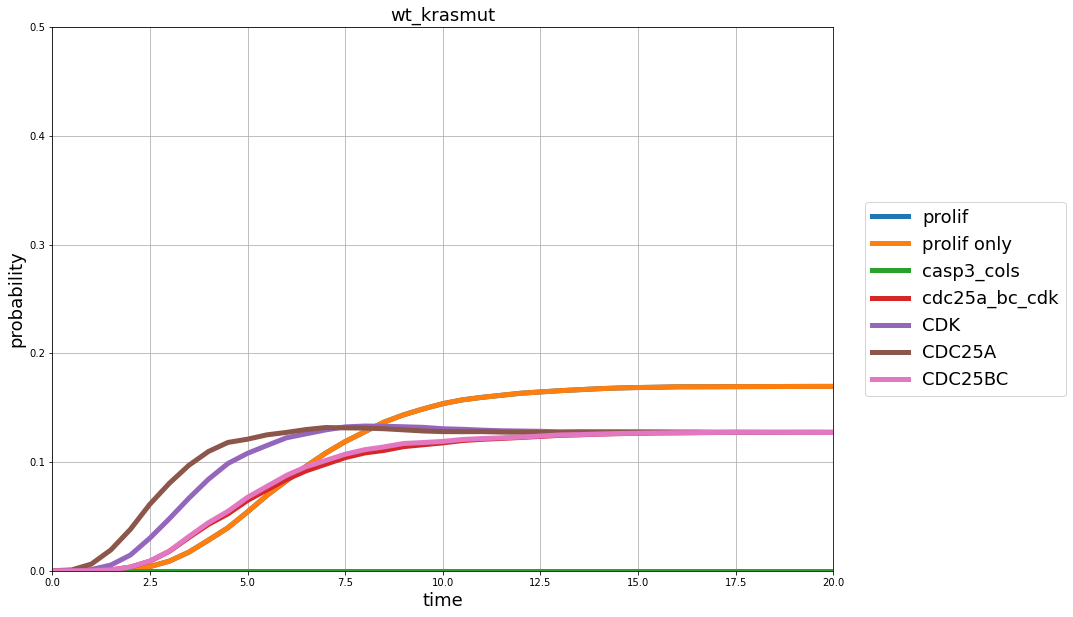

In [427]:
states_probtraj_wt=run_WT_allinputs.get_states_probtraj()
string_cellfates=["Prolif","CASP3","CDK","CDC25A","CDC25B"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_wt,string_cellfates)
[prolif_cols,casp3_cols,CDK_cols,CDC25A_cols,CDC25BC_cols]=cellfate_truthvals
list_truthval=[prolif_cols,prolif_cols&~casp3_cols,casp3_cols,CDK_cols&CDC25A_cols&CDC25BC_cols,\
               CDK_cols,CDC25A_cols,CDC25BC_cols]
list_labels=["prolif","prolif only","casp3_cols","cdc25a_bc_cdk","CDK","CDC25A","CDC25BC"]
str_plotname="_krasmut"; plot_pars=[14,10,18,5,0.5,20]; model_name='wt'
plot_cell_fates(states_probtraj_wt,model_name,str_plotname,plot_pars,list_truthval,list_labels,""); plt.grid()

## KRAS mutation

In [428]:
krasmut=maboss.copy_and_mutate(WT,["RAS"],"ON"); 
# mut_CHEKi = mut_BRAF_ON.copy(); mut_CHEKi.mutate("CHEK1", "OFF")
krasmut.get_initial_state()
krasmut_run=krasmut.run()

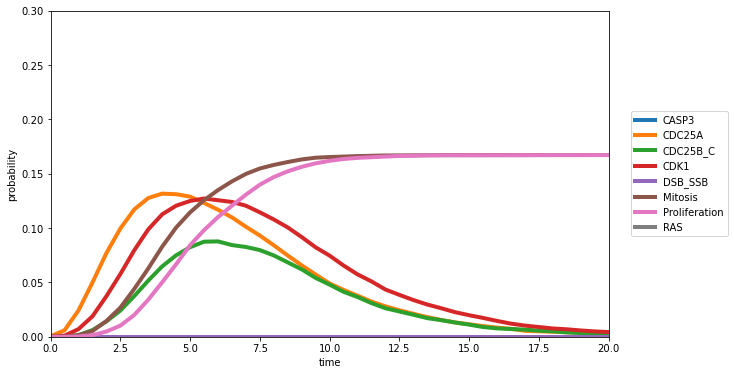

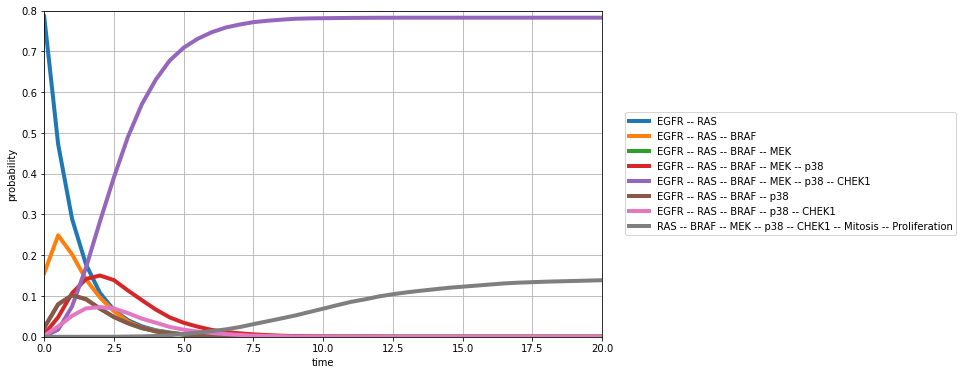

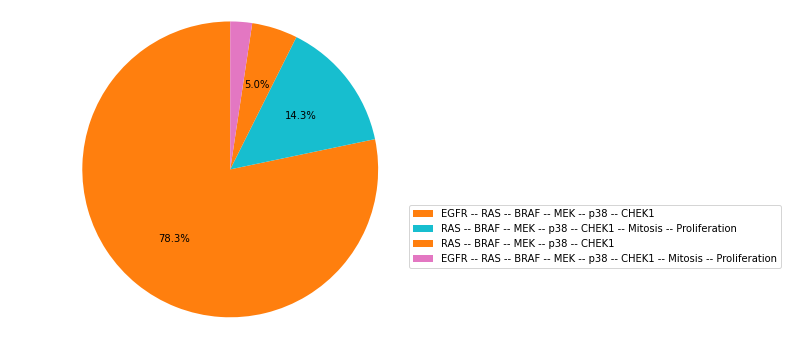

In [429]:
fig_pars=[4,10,6,"time","probability",20]; 
nodes_string=['CDK1','CDC25A','CDC25B_C','DSB_SSB','RAS','Mitosis','Proliferation','CASP3']
plot_node_dynamics(krasmut_run,nodes_string,fig_pars); plt.ylim([0,0.3])

plot_states_larger_prob_x(krasmut_run,0.05,[4,10,6,"time","probability",20]); plt.ylim([0,0.8]); plt.grid()

# plot_states_larger_prob_x(krasmut_run,0.05,[3,10,6,"time","probability",20])
krasmut_run.plot_piechart(); fig_state_piechart=plt.gcf(); fig_state_piechart.set_size_inches(8,6);

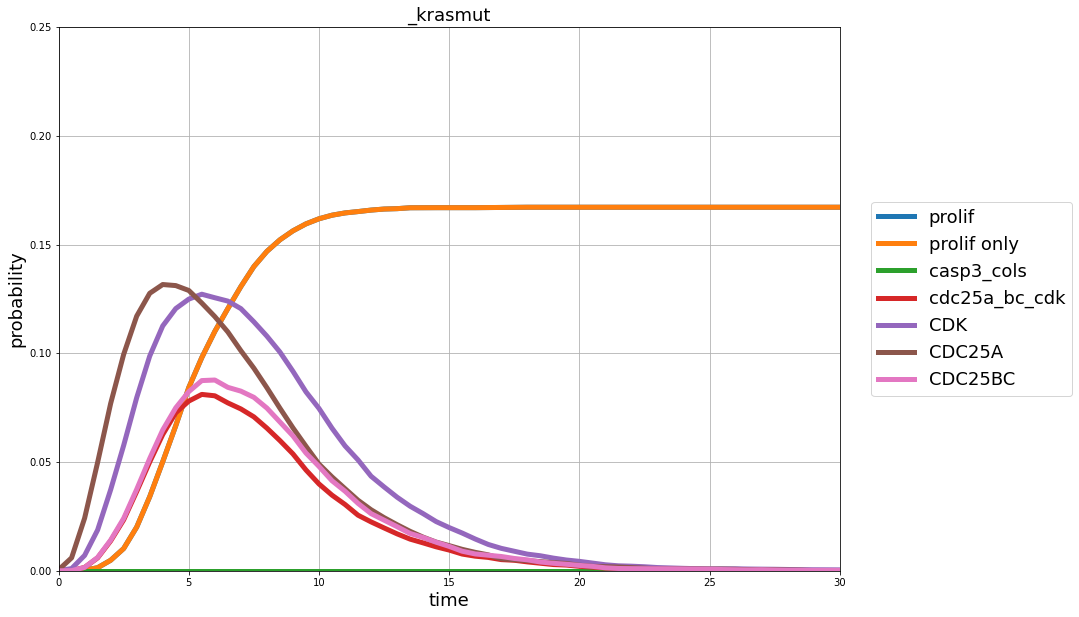

In [430]:
# krasmut_nodnadam_model=krasmut_run.copy() # maboss.copy_and_mutate(mutant_simulation, ["K_N_HRAS"], "ON")
# turn off DNA damage
# krasmut_nodnadam_model.network.set_istate("DSB_SSB",[1,0]);krasmut_nodnadam_results=krasmut_nodnadam_model.run()
states_probtraj_krasmut=krasmut_run.get_states_probtraj()

string_cellfates=["Prolif","CASP3","CDK","CDC25A","CDC25B"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut,string_cellfates)
[prolif_cols,casp3_cols,CDK_cols,CDC25A_cols,CDC25BC_cols]=cellfate_truthvals
list_truthval=[prolif_cols,prolif_cols&~casp3_cols,casp3_cols,CDK_cols&CDC25A_cols&CDC25BC_cols,\
               CDK_cols,CDC25A_cols,CDC25BC_cols]
list_labels=["prolif","prolif only","casp3_cols","cdc25a_bc_cdk","CDK","CDC25A","CDC25BC"]
str_plotname="_krasmut"; plot_pars=[14,10,18,5,0.25,30]; model_name=''
plot_cell_fates(states_probtraj_krasmut,model_name,str_plotname,plot_pars,list_truthval,list_labels,""); plt.grid()

# KRASmut+DNA damage

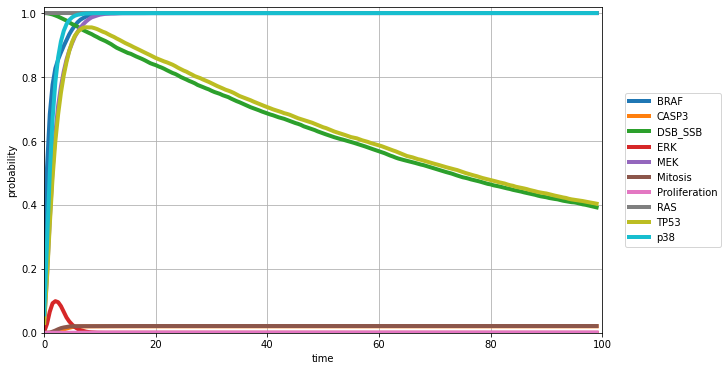

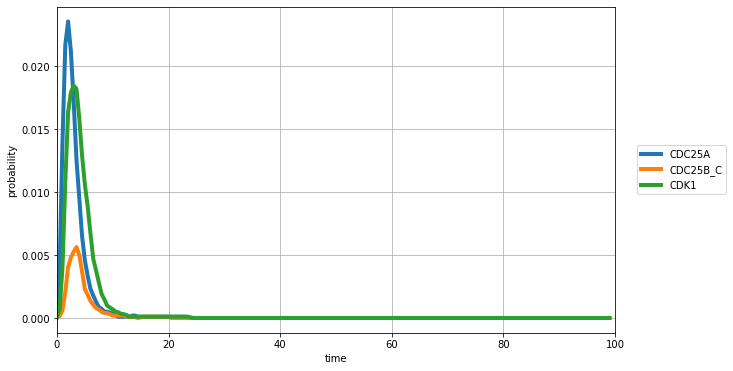

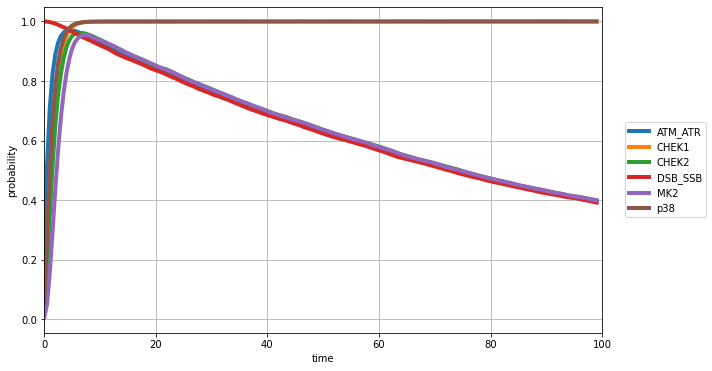

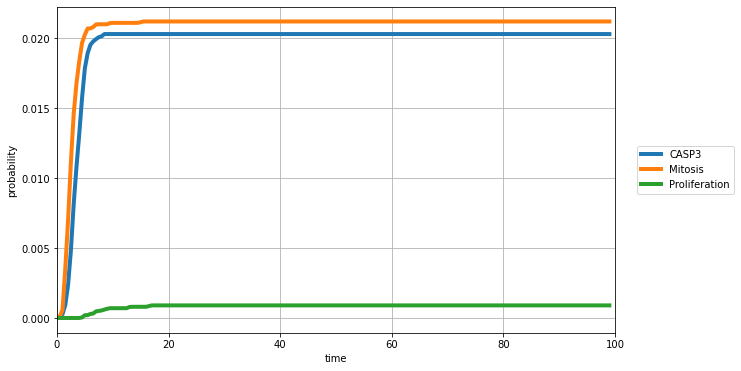

In [432]:
krasmut_dnadam=maboss.copy_and_mutate(WT, ["RAS"], "ON"); 
# krasmut_chek1off.mutate("CHEK1","OFF")
krasmut_dnadam.network.set_istate('DSB_SSB',[0,1])
krasmut_dnadam_run=krasmut_dnadam.run()
# krasmut_dnadam.get_initial_state()
fig_pars=[4,10,6,"time","probability",1e2]; 
nodes_string=['RAS','BRAF','MEK','ERK','p38','DSB_SSB','TP53','Mitosis','Proliferation','CASP3']
plot_node_dynamics(krasmut_dnadam_run,nodes_string,fig_pars); plt.grid(); plt.ylim([0,1.02])
plot_node_dynamics(krasmut_dnadam_run,['CDK1','CDC25A','CDC25B_C'],fig_pars); plt.grid()
plot_node_dynamics(krasmut_dnadam_run,['p38','CHEK1','CHEK2','MK2','ATM_ATR','DSB_SSB'],fig_pars); plt.grid()
plot_node_dynamics(krasmut_dnadam_run,['Mitosis','Proliferation','CASP3'],fig_pars); plt.grid()

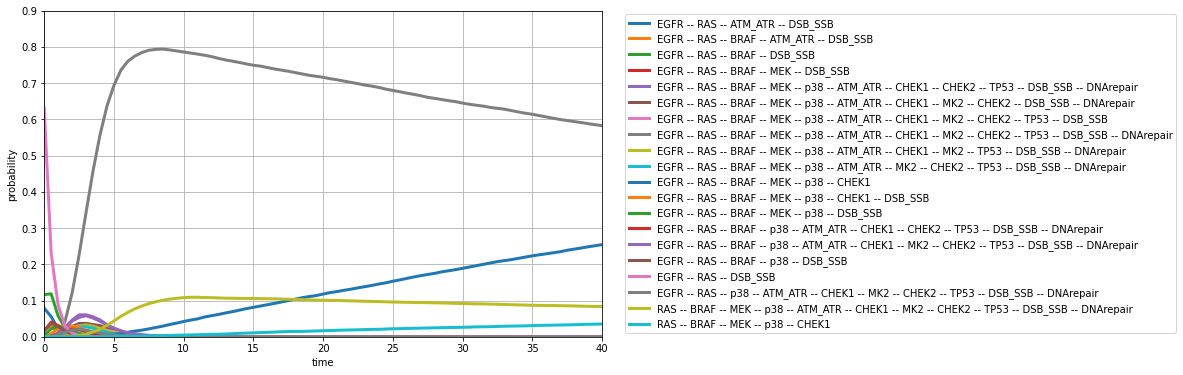

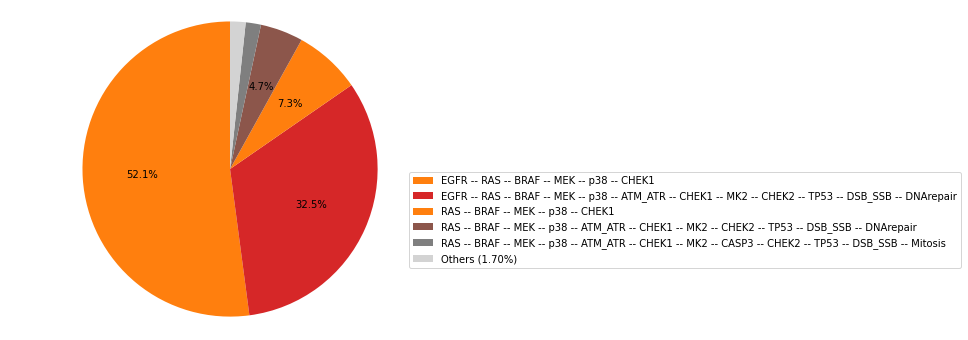

In [433]:
plot_states_larger_prob_x(krasmut_dnadam_run,0.02,[3,10,6,"time","probability",40])
plt.grid(); plt.ylim([0,0.9])
krasmut_dnadam_run.plot_piechart(); fig_state_piechart=plt.gcf(); fig_state_piechart.set_size_inches(8,6);


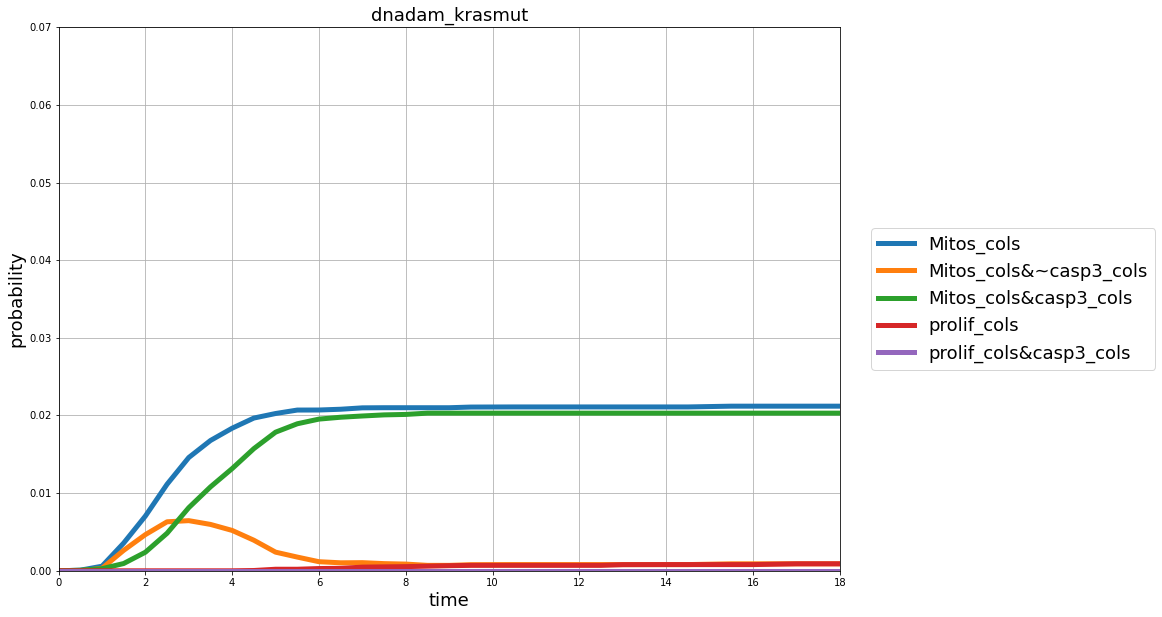

In [434]:
states_probtraj_krasmut_dnadam=krasmut_dnadam_run.get_states_probtraj()

string_cellfates=["Prolif","CASP3","DSB_SSB","Mitos"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut_dnadam,string_cellfates)
[prolif_cols,casp3_cols,dsb_ssb_cols,Mitos_cols]=cellfate_truthvals
list_truthval=[Mitos_cols,\
               Mitos_cols&~casp3_cols,\
               Mitos_cols&casp3_cols,\
              prolif_cols,\
              prolif_cols&casp3_cols]
list_labels=["Mitos_cols",\
             "Mitos_cols&~casp3_cols",\
             "Mitos_cols&casp3_cols",\
            "prolif_cols",\
            "prolif_cols&casp3_cols"]
str_plotname="_krasmut"; plot_pars=[14,10,18,5,0.07,18]; model_name='dnadam'
plot_cell_fates(states_probtraj_krasmut_dnadam,model_name,str_plotname,plot_pars,list_truthval,list_labels,"")
plt.grid()

In [435]:
np.sum(states_probtraj_krasmut_dnadam.iloc[-1,casp3_cols])


0.0203

# KRASMUT + DNADAM + CHEK1off

(0.0, 1.02)

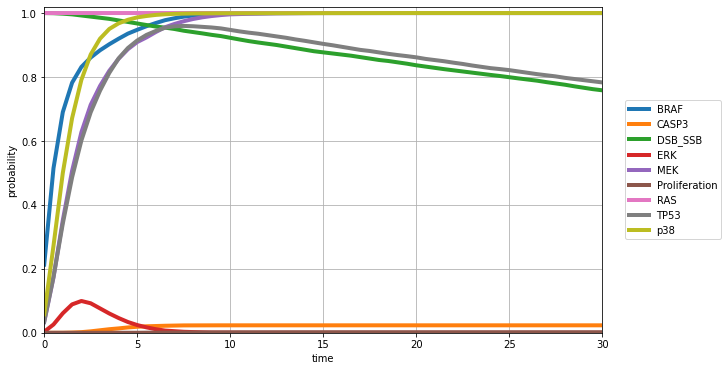

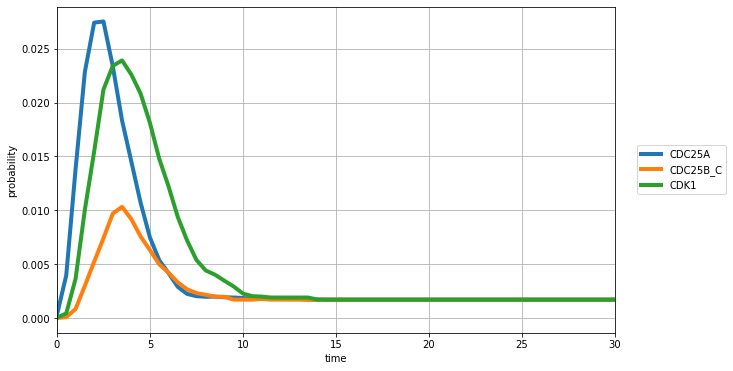

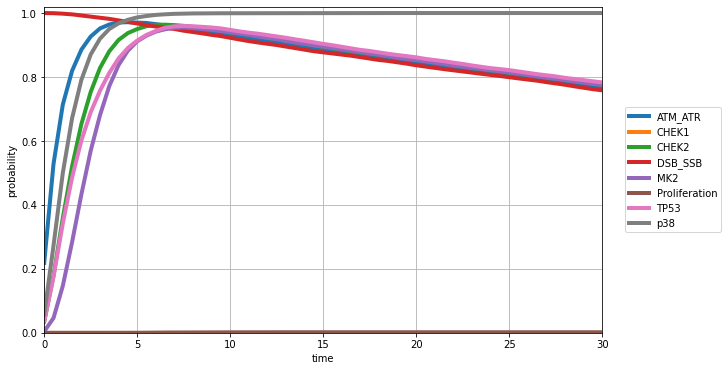

In [436]:
krasmut_dnadam_chek1off=maboss.copy_and_mutate(WT,["RAS"],"ON"); krasmut_dnadam_chek1off.mutate("CHEK1","OFF")
krasmut_dnadam_chek1off.network.set_istate('DSB_SSB',[0,1]);krasmut_dnadam_chek1off.network.set_istate('RAS',[0,1])
krasmut_dnadam_chek1off_run=krasmut_dnadam_chek1off.run()

fig_pars=[4,10,6,"time","probability",30]; 
# nodes_string=['CDK1','CDC25A','CDC25B_C','DSB_SSB','RAS','Proliferation','CASP3']
# plot_node_dynamics(krasmut_dnadam_chek1off_run,nodes_string,fig_pars); plt.grid(); plt.ylim([0,1.01])
nodes_string=['RAS','BRAF','MEK','ERK','p38','DSB_SSB','TP53','Proliferation','CASP3']
plot_node_dynamics(krasmut_dnadam_chek1off_run,nodes_string,fig_pars); plt.grid(); plt.ylim([0,1.02])
plot_node_dynamics(krasmut_dnadam_chek1off_run,['CDK1','CDC25A','CDC25B_C'],fig_pars); plt.grid()
plot_node_dynamics(krasmut_dnadam_chek1off_run,['p38','CHEK1','CHEK2','MK2','ATM_ATR',\
                          'TP53','DSB_SSB','Proliferation'],fig_pars); plt.grid(); plt.ylim([0,1.02])

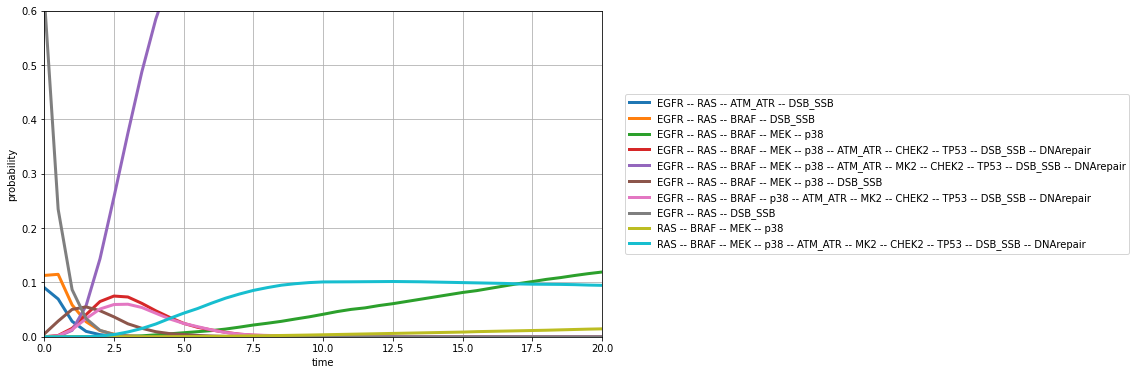

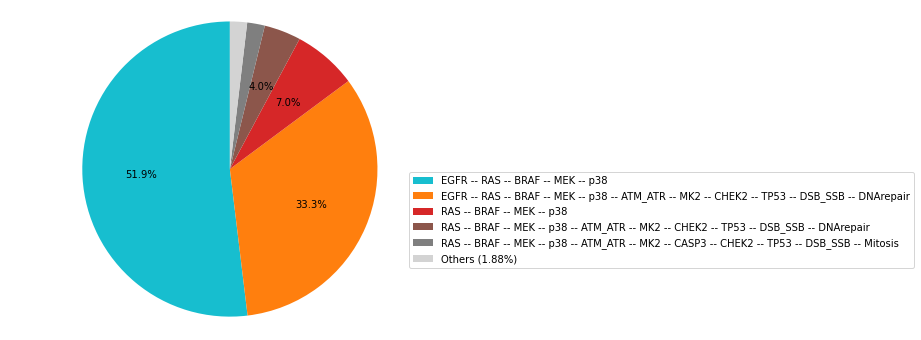

In [437]:
plot_states_larger_prob_x(krasmut_dnadam_chek1off_run,0.05,[3,10,6,"time","probability",20])
plt.grid(); plt.ylim([0,0.6])
krasmut_dnadam_chek1off_run.plot_piechart(); fig_state_piechart=plt.gcf(); fig_state_piechart.set_size_inches(8,6);


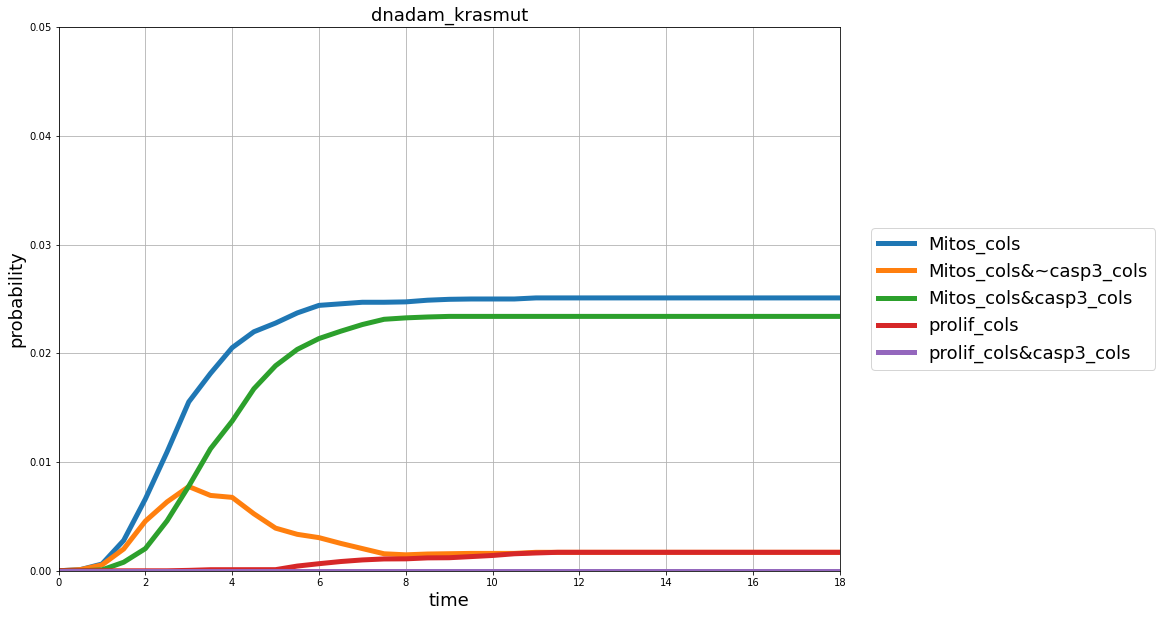

In [438]:
states_probtraj_krasmut_dnadam_chek1off=krasmut_dnadam_chek1off_run.get_states_probtraj()

string_cellfates=["Prolif","CASP3","Mitosis","TP53"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut_dnadam_chek1off,string_cellfates)
[prolif_cols,casp3_cols,Mitos_cols,tp53_cols]=cellfate_truthvals
list_truthval=[Mitos_cols,\
               Mitos_cols&~casp3_cols,\
               Mitos_cols&casp3_cols,\
              prolif_cols,\
              prolif_cols&casp3_cols]
list_labels=["Mitos_cols",\
              "Mitos_cols&~casp3_cols",\
              "Mitos_cols&casp3_cols",\
              "prolif_cols",\
              "prolif_cols&casp3_cols"]
str_plotname="_krasmut"; plot_pars=[14,10,18,5,0.05,18]; model_name='dnadam'
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1off,model_name,\
                str_plotname,plot_pars,list_truthval,list_labels,"")
plt.grid()

In [439]:
np.sum(states_probtraj_krasmut_dnadam_chek1off.iloc[-1,casp3_cols])

0.0234

# KRASMUT + DNADAM + MK2off

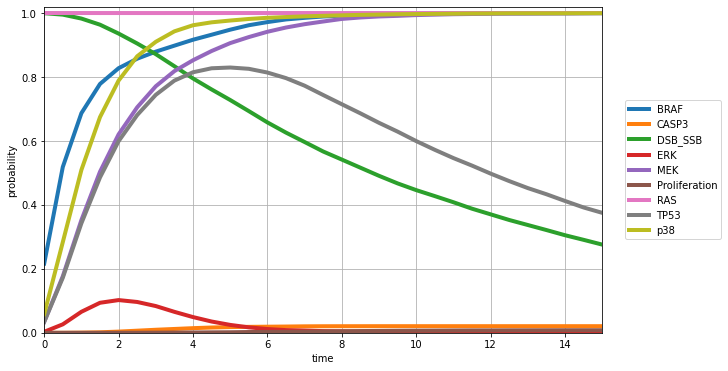

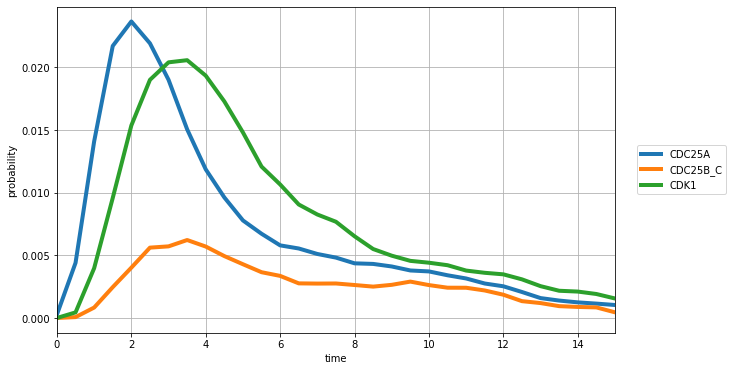

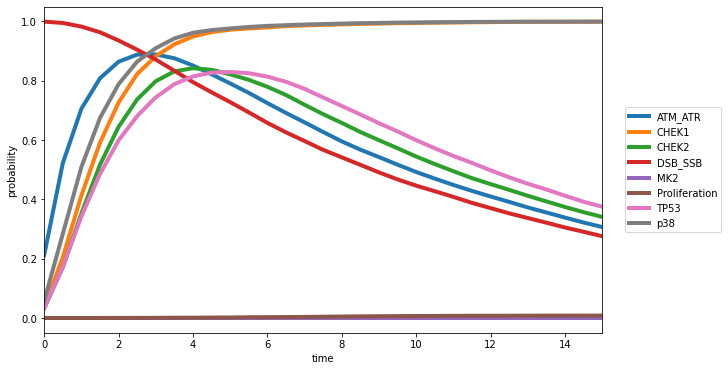

In [385]:
krasmut_dnadam_mk2off=maboss.copy_and_mutate(WT,["RAS"],"ON"); krasmut_dnadam_mk2off.mutate("MK2","OFF")
krasmut_dnadam_mk2off.network.set_istate('DSB_SSB',[0,1]);krasmut_dnadam_mk2off.network.set_istate('RAS',[0,1])
krasmut_dnadam_mk2off_run=krasmut_dnadam_mk2off.run()

fig_pars=[4,10,6,"time","probability",15]; 
# nodes_string=['CDK1','CDC25A','CDC25B_C','DSB_SSB','RAS','Proliferation','CASP3']
# plot_node_dynamics(krasmut_dnadam_mk2off_run,nodes_string,fig_pars); plt.grid(); plt.ylim([0,1.01])
nodes_string=['RAS','BRAF','MEK','ERK','p38','DSB_SSB','TP53','Proliferation','CASP3']
plot_node_dynamics(krasmut_dnadam_mk2off_run,nodes_string,fig_pars); plt.grid(); plt.ylim([0,1.02])
plot_node_dynamics(krasmut_dnadam_mk2off_run,['CDK1','CDC25A','CDC25B_C'],fig_pars); plt.grid()
plot_node_dynamics(krasmut_dnadam_mk2off_run,['p38','CHEK1','CHEK2','MK2','ATM_ATR',\
                                                'TP53','DSB_SSB','Proliferation'],fig_pars); 

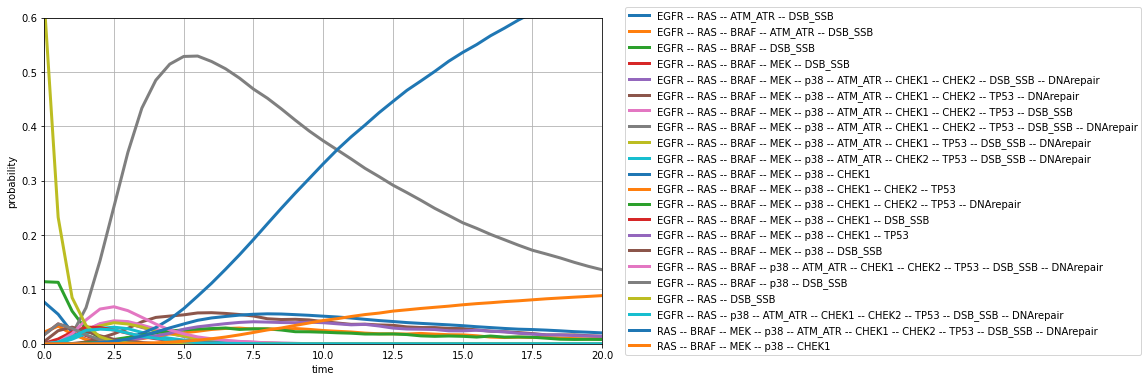

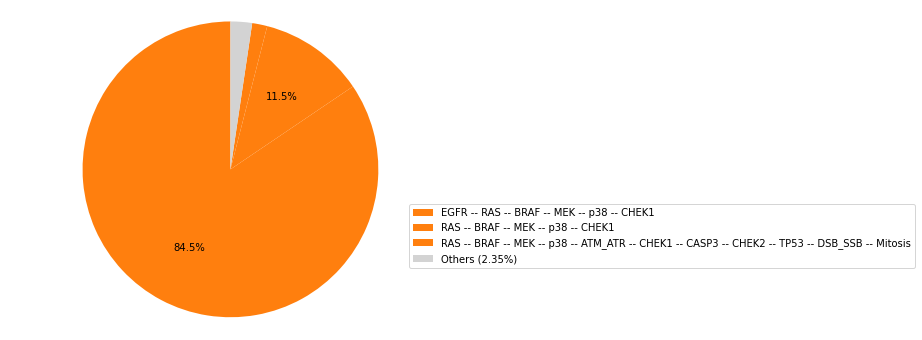

In [386]:
plot_states_larger_prob_x(krasmut_dnadam_mk2off_run,0.025,[3,10,6,"time","probability",20])
plt.grid(); plt.ylim([0,0.6])
krasmut_dnadam_mk2off_run.plot_piechart(); fig_state_piechart=plt.gcf(); fig_state_piechart.set_size_inches(8,6);


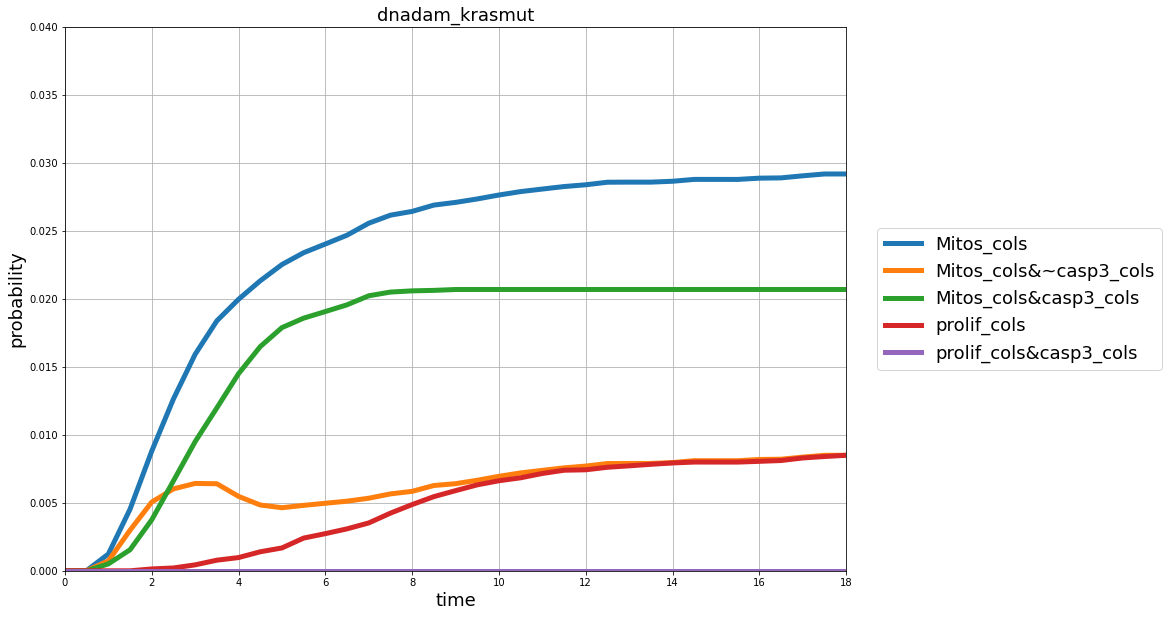

In [389]:
states_probtraj_krasmut_dnadam_mk2off=krasmut_dnadam_mk2off_run.get_states_probtraj()

string_cellfates=["Prolif","CASP3","Mitosis","TP53"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut_dnadam_mk2off,string_cellfates)
[prolif_cols,casp3_cols,Mitos_cols,tp53_cols]=cellfate_truthvals
list_truthval=[Mitos_cols,\
               Mitos_cols&~casp3_cols,\
               Mitos_cols&casp3_cols,\
              prolif_cols,\
              prolif_cols&casp3_cols]
list_labels=["Mitos_cols",\
               "Mitos_cols&~casp3_cols",\
               "Mitos_cols&casp3_cols",\
              "prolif_cols",\
              "prolif_cols&casp3_cols"]
str_plotname="_krasmut"; plot_pars=[14,10,18,5,0.04,18]; model_name='dnadam'
plot_cell_fates(states_probtraj_krasmut_dnadam_mk2off,model_name,\
                str_plotname,plot_pars,list_truthval,list_labels,"")
plt.grid()

# prolif_cols,\
#             prolif_cols&~casp3_cols,\
#              casp3_cols,\
#               casp3_cols&prolif_cols,\
#               dsb_ssb_cols&prolif_cols,\
#               ~dsb_ssb_cols&tp53_cols&casp3_cols,\
#              dsb_ssb_cols&tp53_cols&casp3_cols,\
#              dsb_ssb_cols&~tp53_cols&casp3_cols

In [390]:
np.sum(states_probtraj_krasmut_dnadam_mk2off.iloc[-1,casp3_cols])

0.020700000000000003

# KRASMUT + DNADAM + CHEK1off + MK2off

(0.0, 1.02)

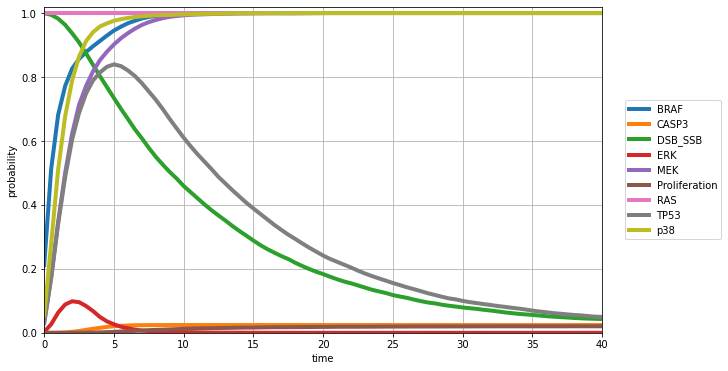

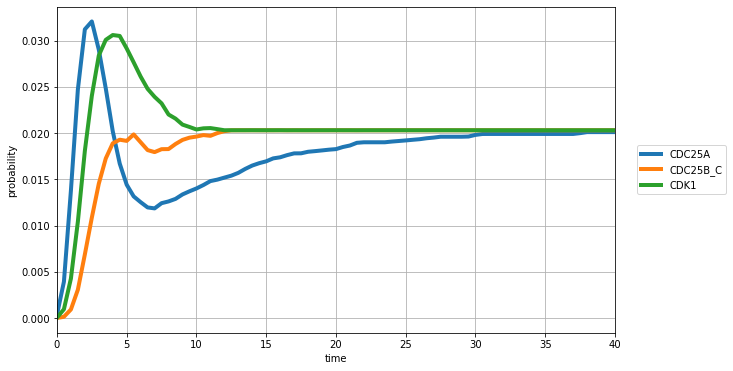

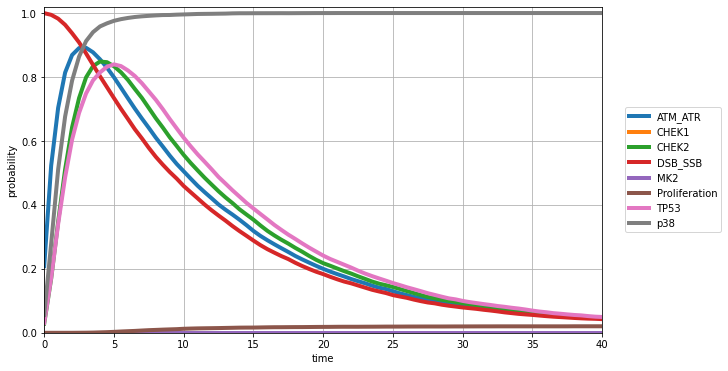

In [391]:
krasmut_dnadam_chek1mk2off=maboss.copy_and_mutate(WT, ["RAS"], "ON"); 
krasmut_dnadam_chek1mk2off.mutate("MK2","OFF"); krasmut_dnadam_chek1mk2off.mutate("CHEK1","OFF")
krasmut_dnadam_chek1mk2off.network.set_istate('DSB_SSB',[0,1]);
krasmut_dnadam_chek1mk2off.network.set_istate('RAS',[0,1])
krasmut_dnadam_chek1mk2off_run=krasmut_dnadam_chek1mk2off.run()

fig_pars=[4,10,6,"time","probability",40]; 
nodes_string=['RAS','BRAF','MEK','ERK','p38','DSB_SSB','TP53','Proliferation','CASP3']
# krasmut_dnadam_chek1mk2off.get_mutations()
# krasmut_dnadam_chek1mk2off.get_initial_state()
plot_node_dynamics(krasmut_dnadam_chek1mk2off_run,nodes_string,fig_pars); plt.grid(); plt.ylim([0,1.02])
plot_node_dynamics(krasmut_dnadam_chek1mk2off_run,['CDK1','CDC25A','CDC25B_C'],fig_pars); plt.grid()
plot_node_dynamics(krasmut_dnadam_chek1mk2off_run,['p38','CHEK1','CHEK2','MK2','ATM_ATR',\
                               'TP53','DSB_SSB','Proliferation'],fig_pars); plt.grid(); plt.ylim([0,1.02])

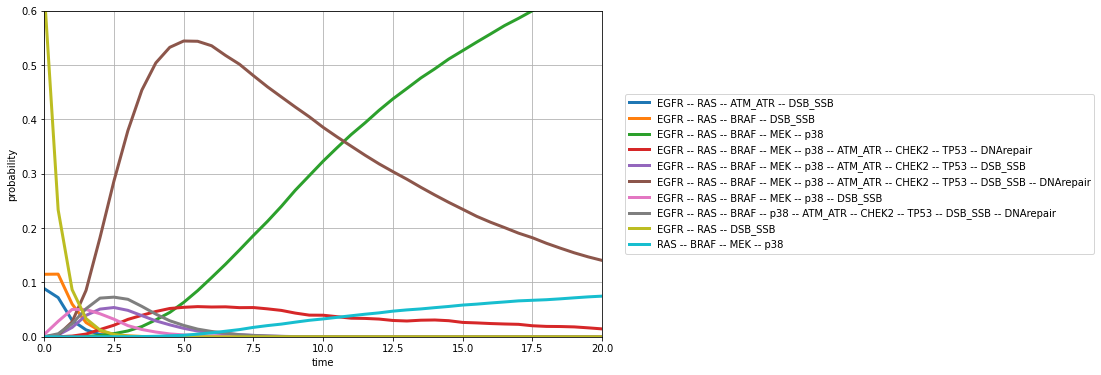

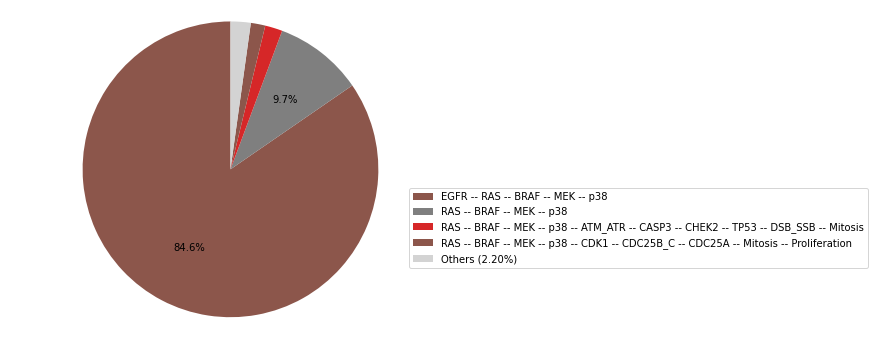

In [392]:
plot_states_larger_prob_x(krasmut_dnadam_chek1mk2off_run,0.05,[3,10,6,"time","probability",20])
plt.grid(); plt.ylim([0,0.6])
krasmut_dnadam_chek1mk2off_run.plot_piechart(); fig_state_piechart=plt.gcf(); fig_state_piechart.set_size_inches(8,6);


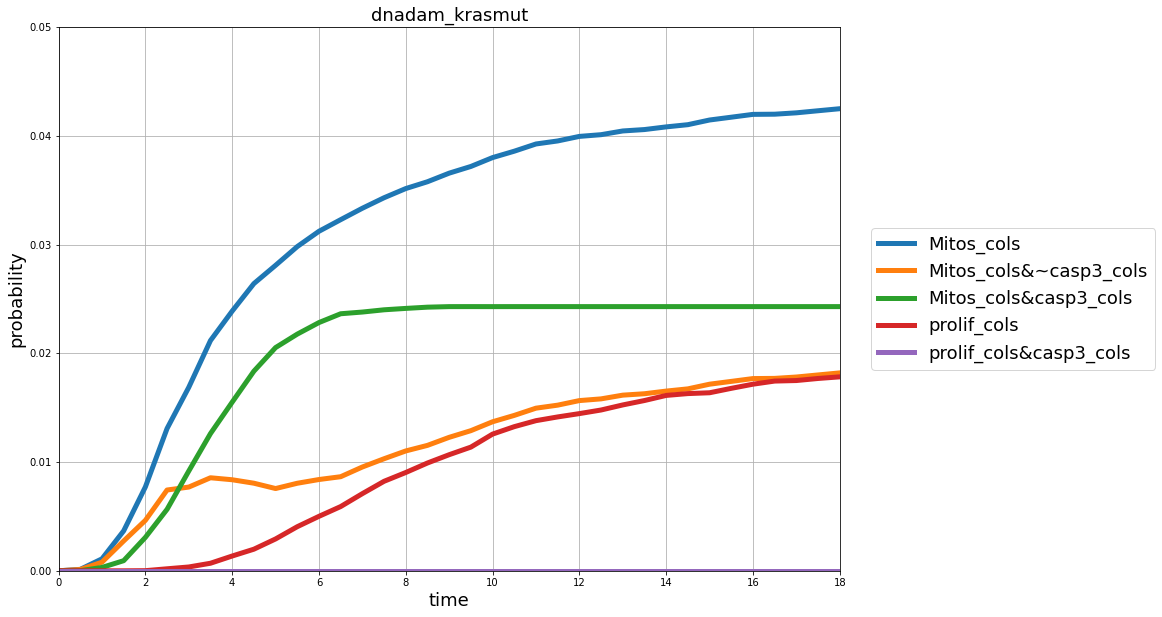

In [393]:
states_probtraj_krasmut_dnadam_chek1mk2off=krasmut_dnadam_chek1mk2off_run.get_states_probtraj()

string_cellfates=["Prolif","CASP3","Mitosis","TP53"]
cellfate_truthvals=fcn_truthval_states(states_probtraj_krasmut_dnadam_chek1mk2off,string_cellfates)
[prolif_cols,casp3_cols,Mitos_cols,tp53_cols]=cellfate_truthvals
list_truthval=[Mitos_cols,\
               Mitos_cols&~casp3_cols,\
               Mitos_cols&casp3_cols,\
              prolif_cols,\
              prolif_cols&casp3_cols]
list_labels=["Mitos_cols",\
               "Mitos_cols&~casp3_cols",\
               "Mitos_cols&casp3_cols",\
              "prolif_cols",\
              "prolif_cols&casp3_cols"]
str_plotname="_krasmut"; plot_pars=[14,10,18,5,0.05,18]; model_name='dnadam'
plot_cell_fates(states_probtraj_krasmut_dnadam_chek1mk2off,model_name,\
                str_plotname,plot_pars,list_truthval,list_labels,"")
plt.grid()

In [394]:
np.sum(states_probtraj_krasmut_dnadam_chek1mk2off.iloc[-1,casp3_cols])

0.024300000000000002

In [395]:
krasmut_dnadam_run.get_last_nodes_probtraj()

ATM_ATR      BRAF   CASP3     CHEK1     CHEK2  DNArepair   DSB_SSB  \
49.0000  0.024062  1.000001  0.0154  1.000001  0.025317   0.011391  0.023107   

             EGFR       MEK       MK2  Mitosis  Proliferation       RAS  \
49.0000  0.861601  1.000001  0.025274   0.0258         0.0104  1.000001   

             TP53       p38  
49.0000  0.026676  1.000001

# All results as one

In [ ]:
# plot the different mutants on subplots

# run_WT_allinputs,
# krasmut_run,krasmut_dnadam_run,
# krasmut_dnadam_chek1off_run,krasmut_dnadam_mk2off_run,krasmut_dnadam_chek1mk2off_run
kras_all_conds_lastnodes_prob=pd.concat([
           run_WT_allinputs.get_last_nodes_probtraj(),
           krasmut_run.get_last_nodes_probtraj(),
           krasmut_dnadam_run.get_last_nodes_probtraj(),
           krasmut_dnadam_chek1off_run.get_last_nodes_probtraj(), 
           krasmut_dnadam_mk2off_run.get_last_nodes_probtraj(), 
           krasmut_dnadam_chek1mk2off_run.get_last_nodes_probtraj()],ignore_index=True,sort=True)
kras_all_conds_lastnodes_prob.replace(np.nan,0)
barplot_titles=["wt, no DNAdam","kras$\Delta$ (no_inhib)","kras$\Delta$, DNAdam no_inhib",
                "kras$\Delta$, DNAdam chek1i",
                "kras$\Delta$, DNAdam mk2i","kras$\Delta$, DNAdam chek1i+mk2i"]
sel_nodes=['CASP3','Proliferation','DSB_SSB'] # ,'SSB','mit'
truthvals=kras_all_conds_lastnodes_prob.columns.str.contains(str.join("|",sel_nodes))

r1 = np.arange(np.sum(truthvals))*8

# plt.figure(figsize=(plot_pars[0],plot_pars[1]));
# for n in range(0,np.shape(kras_all_conds_lastnodes_prob)[0],1):
#     last_nodes=kras_all_conds_lastnodes_prob.iloc[[n]].loc[:,truthvals]
#     # if n==(np.shape(kras_all_conds_lastnodes_prob)[0]-1):
#     #    tick_label_str=last_nodes.columns
#     # else:
#     #    tick_label_str=""   
#     plt.barh(r1+n*1,last_nodes.values[0],tick_label=last_nodes.columns)
# 
# fontsize_val=12; plt.legend(barplot_titles,loc="lower right",fontsize=12)
# # plt.savefig("figures/"+model_name+"krasmut_dnadam_all.png",bbox_inches='tight')
# plt.ylim([0,22]); plt.xscale('log'); plt.grid(which='both',axis="x",ls='--') 

In [5]:
modelfiles=[f for f in os.listdir('.') if (os.path.isfile(f) & ('.bnet' in f))]
# fig,axs=plt.subplots(2,2,figsize=(20,15)); plt.suptitle(filename,fontsize=15)
paramsets=list(itertools.product([1e-1,1,1e1],repeat=5))
len(paramsets)

243

# Plot cell fate outputs for diff trans rate vals

In [ ]:
# subplots
modelfiles=[f for f in os.listdir('.') if (os.path.isfile(f) & ('.bnet' in f))]
# fig,axs=plt.subplots(2,2,figsize=(20,15)); plt.suptitle(filename,fontsize=15)

paramsets=list(itertools.product([1e-1,1,1e1],repeat=5))
# filename=modelfiles[0]
# WT.param["$u_CASP3"]=1e2; WT.param["$u_Mitosis"]=1e2

barplot_titles=["wt, no DNAdam","kras$\Delta$, no DNAdam, 0/0","kras$\Delta$, DNAdam, 0/0",
            "kras$\Delta$, DNAdam, chek1i/0","kras$\Delta$, DNAdam, 0/mk2i","kras$\Delta$, DNAdam, chek1i/mk2i"]
parscan_results_allmodels=[]
params_str=['d_DSB_SSB','u_CDC25*','u_CDK1','u_Mitosis','u_CASP3']

for filename in modelfiles:
    parscan_results=[];
    WT=maboss.loadBNet(filename); WT.param["max_time"]=8e2; WT.param['time_tick']=0.5; WT.param['sample_count']=2e3
    WT.param["thread_count"]=8
    # set initconds
    WT.network.set_istate('EGFR',[0,1]); WT.network.set_istate('DNArepair',[1,0])
    WT.network.set_istate('DSB_SSB',[1,0]); WT.network.set_istate('RAS',[1,0])
    for subpl_cntr in range(len(paramsets)): # range(len(paramsets))
        start=time.time()
        # WT.param["$u_ERK"]=1e2; WT.param["$d_ERK"]=1e-1; # WT.param["$u_ATM_ATR"]=1e-1; WT.param["$d_CHEK1"]=1e2; 
        # WT.param["$u_CASP3"]=1e2 # WT.param["$u_Proliferation"]=1e2;
        WT.param["$d_DSB_SSB"]=paramsets[subpl_cntr][0]; 
        WT.param["$u_CDC25A"]=paramsets[subpl_cntr][1]; WT.param["$u_CDC25B_C"]=paramsets[subpl_cntr][1]; 
        WT.param["$u_CDK1"]=paramsets[subpl_cntr][2]; WT.param["$u_Mitosis"]=paramsets[subpl_cntr][3]; 
        WT.param["$u_CASP3"]=paramsets[subpl_cntr][4];
        WT_run=WT.run()
        #############
        # KRASmut no DNA damage
        krasmut=maboss.copy_and_mutate(WT,["RAS"],"ON"); krasmut_run=krasmut.run()
        #############
        # KRASmut DNA damage
        krasmut_dnadam=maboss.copy_and_mutate(WT,["RAS"],"ON"); krasmut_dnadam.network.set_istate('DSB_SSB',[0,1])
        krasmut_dnadam_run=krasmut_dnadam.run()
        #############
        # KRASmut DNAdam + CHEK1off
        krasmut_dnadam_chek1off=maboss.copy_and_mutate(WT,["RAS"],"ON");krasmut_dnadam_chek1off.mutate("CHEK1","OFF")
        krasmut_dnadam_chek1off.network.set_istate('DSB_SSB',[0,1]);krasmut_dnadam_chek1off.network.set_istate('RAS',[0,1])
        krasmut_dnadam_chek1off_run=krasmut_dnadam_chek1off.run()
        #############
        # KRASMUT + DNADAM + MK2off
        krasmut_dnadam_mk2off=maboss.copy_and_mutate(WT,["RAS"],"ON"); krasmut_dnadam_mk2off.mutate("MK2","OFF")
        krasmut_dnadam_mk2off.network.set_istate('DSB_SSB',[0,1]);krasmut_dnadam_mk2off.network.set_istate('RAS',[0,1])
        krasmut_dnadam_mk2off_run=krasmut_dnadam_mk2off.run()
        #############
        # KRASMUT + DNADAM + CHEK1off + MK2off
        krasmut_dnadam_chek1mk2off=maboss.copy_and_mutate(WT, ["RAS"], "ON"); 
        krasmut_dnadam_chek1mk2off.mutate("MK2","OFF"); krasmut_dnadam_chek1mk2off.mutate("CHEK1","OFF")
        krasmut_dnadam_chek1mk2off.network.set_istate('DSB_SSB',[0,1]);krasmut_dnadam_chek1mk2off.network.set_istate('RAS',[0,1])
        krasmut_dnadam_chek1mk2off_run=krasmut_dnadam_chek1mk2off.run()
        
        # plot the different mutants on subplots
        kras_all_conds_lastnodes_prob=pd.concat([
                   WT_run.get_last_nodes_probtraj(),
                   krasmut_run.get_last_nodes_probtraj(),
                   krasmut_dnadam_run.get_last_nodes_probtraj(),
                   krasmut_dnadam_chek1off_run.get_last_nodes_probtraj(), 
                   krasmut_dnadam_mk2off_run.get_last_nodes_probtraj(), 
                   krasmut_dnadam_chek1mk2off_run.get_last_nodes_probtraj()],ignore_index=True,sort=True)
        kras_all_conds_lastnodes_prob.replace(np.nan,0)
        parscan_results.append(kras_all_conds_lastnodes_prob); # parscan_results=np.asarray(parscan_results)
        end=time.time(); timeiter=np.round(end-start,2);
        # PRINT progress of parscan
        print(timeiter, filename, subpl_cntr)
    parscan_results_allmodels.append(parscan_results)
    

### put it in dataframe
pd_parset=[]; # pd_inner=[]
for modelcntr in range(len(parscan_results_allmodels)):
    for parsetcntr in range(len(parscan_results_allmodels[0])):
        pd_inner=parscan_results_allmodels[modelcntr][parsetcntr].copy()
        # pd_inner['conds']=barplot_titles; pd_inner['model']=modelfiles[modelcntr]
        pd_inner.insert(loc=0,column='conds',value=barplot_titles) 
        pd_inner.insert(loc=1,column='model',value=modelfiles[modelcntr])
        pd_inner.insert(loc=1,column='parset',value=parsetcntr)
        pd_parset.append(pd_inner)

# df.append(df2, ignore_index=True)
pd_parscan_results_allmodels=pd.concat(pd_parset)

# SAVE
parscan_str=str(len(parscan_results))+"parsets"
pd.DataFrame.to_csv(pd_parscan_results_allmodels,'pd_parscan_results_allmodels'+parscan_str+'.csv',index=False);


In [28]:
6*6*3**5

8748

In [479]:
m=0;k=0
truthvals=(pd_parscan_results_allmodels["parset"]==k)&\
    pd_parscan_results_allmodels["model"].str.contains(modelfiles[m])

pd_parscan_results_allmodels[truthvals]
len(parscan_results)

81

# Last values on a heatmap

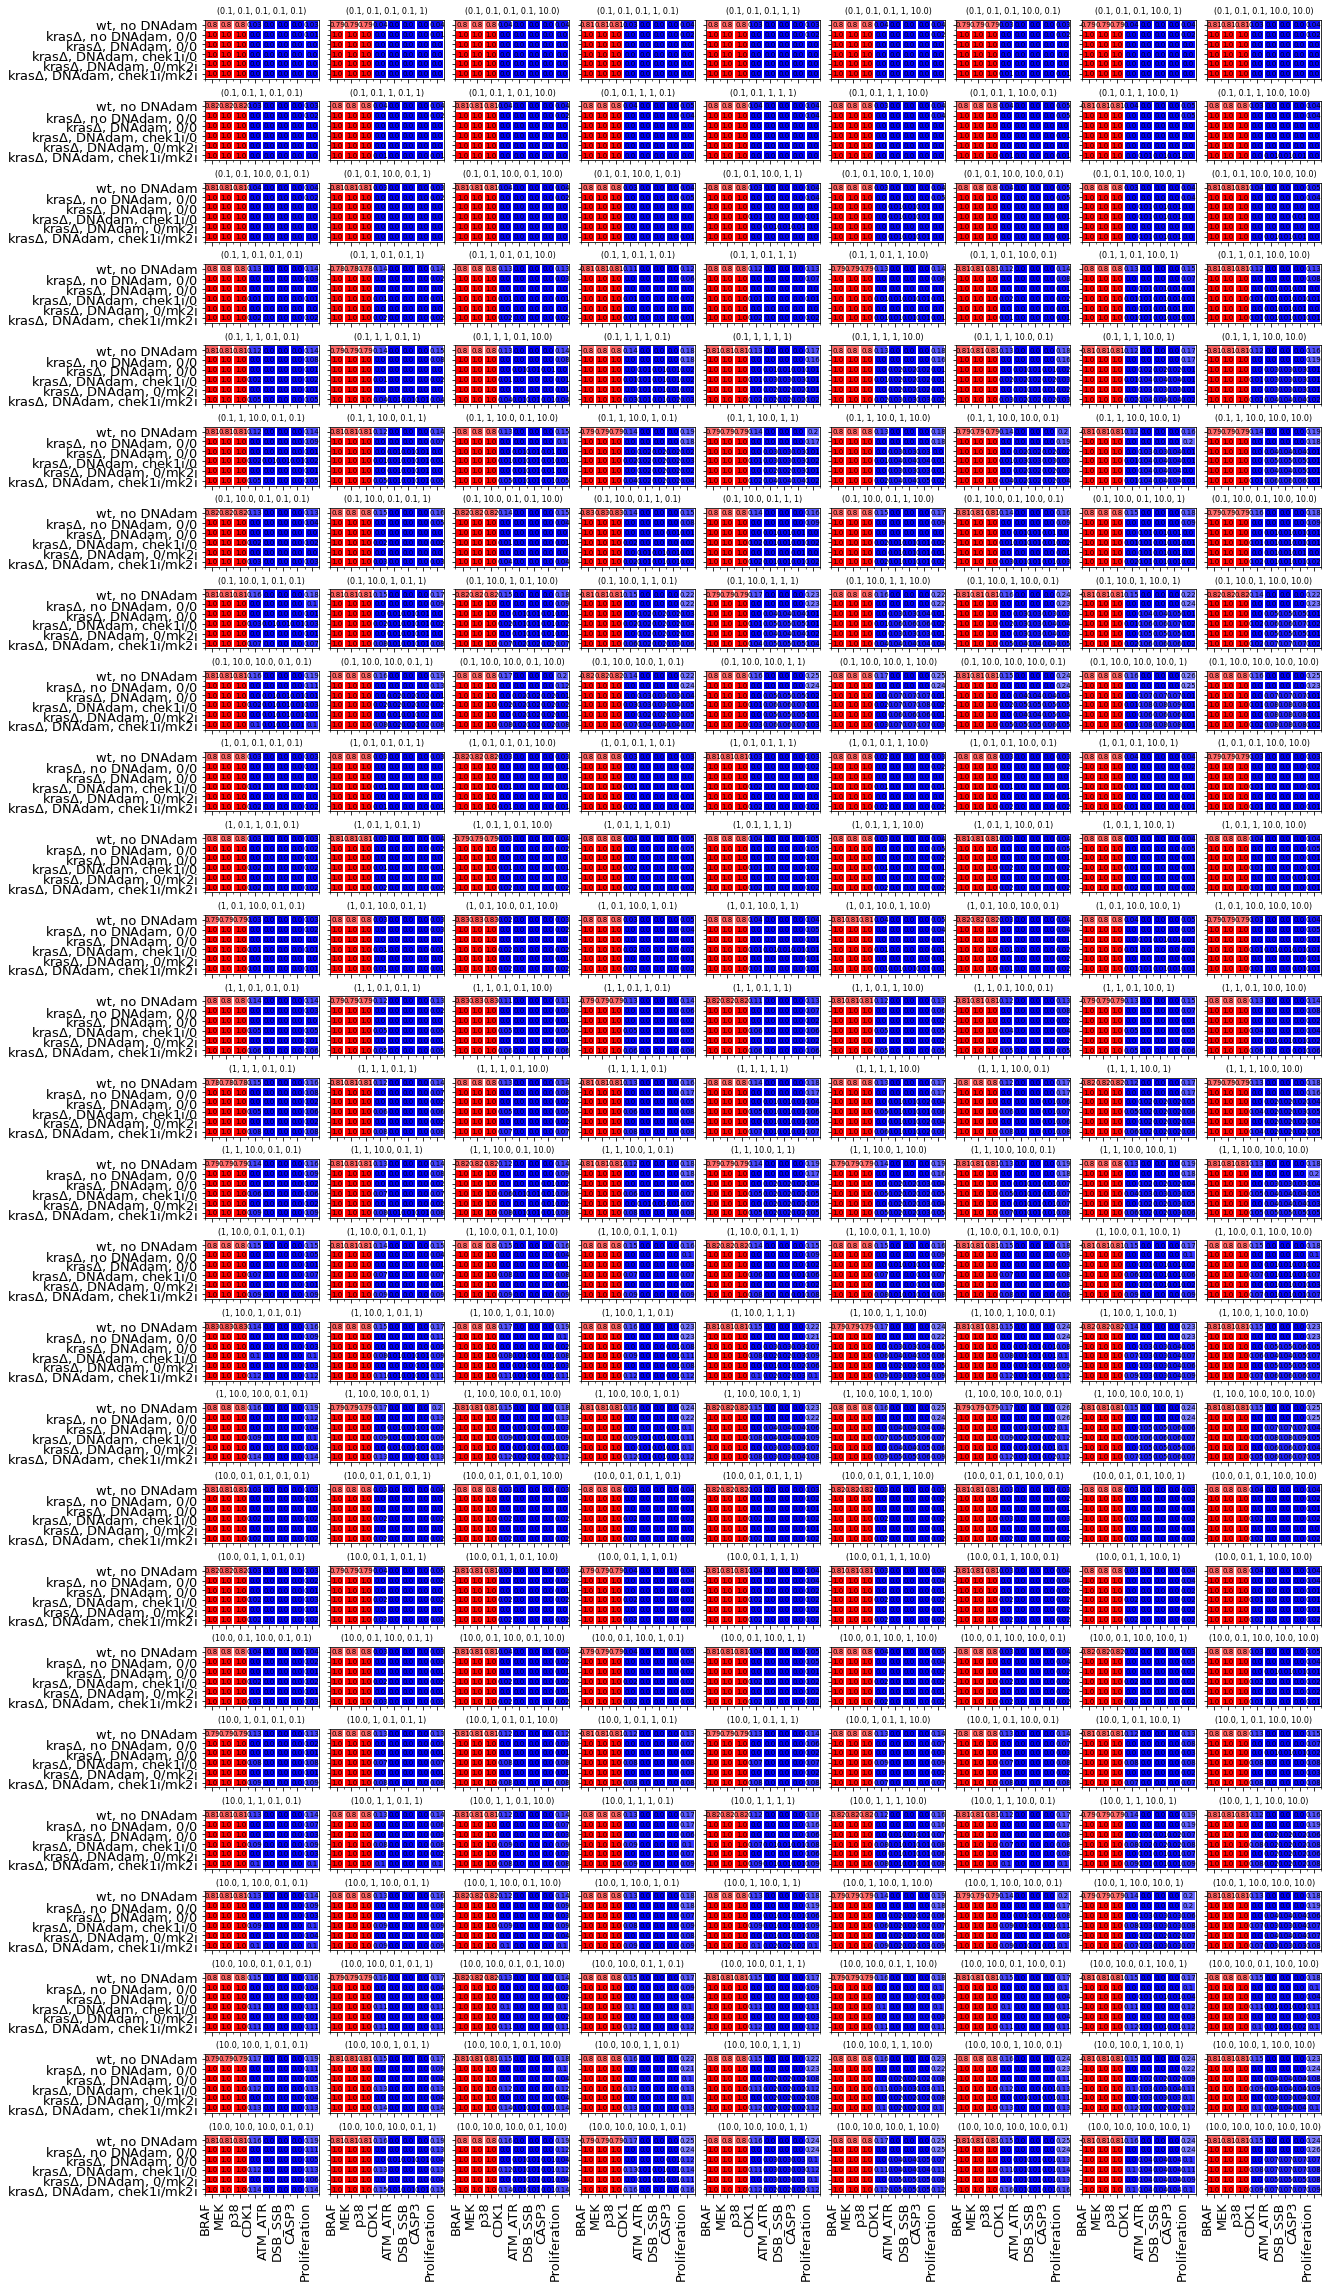

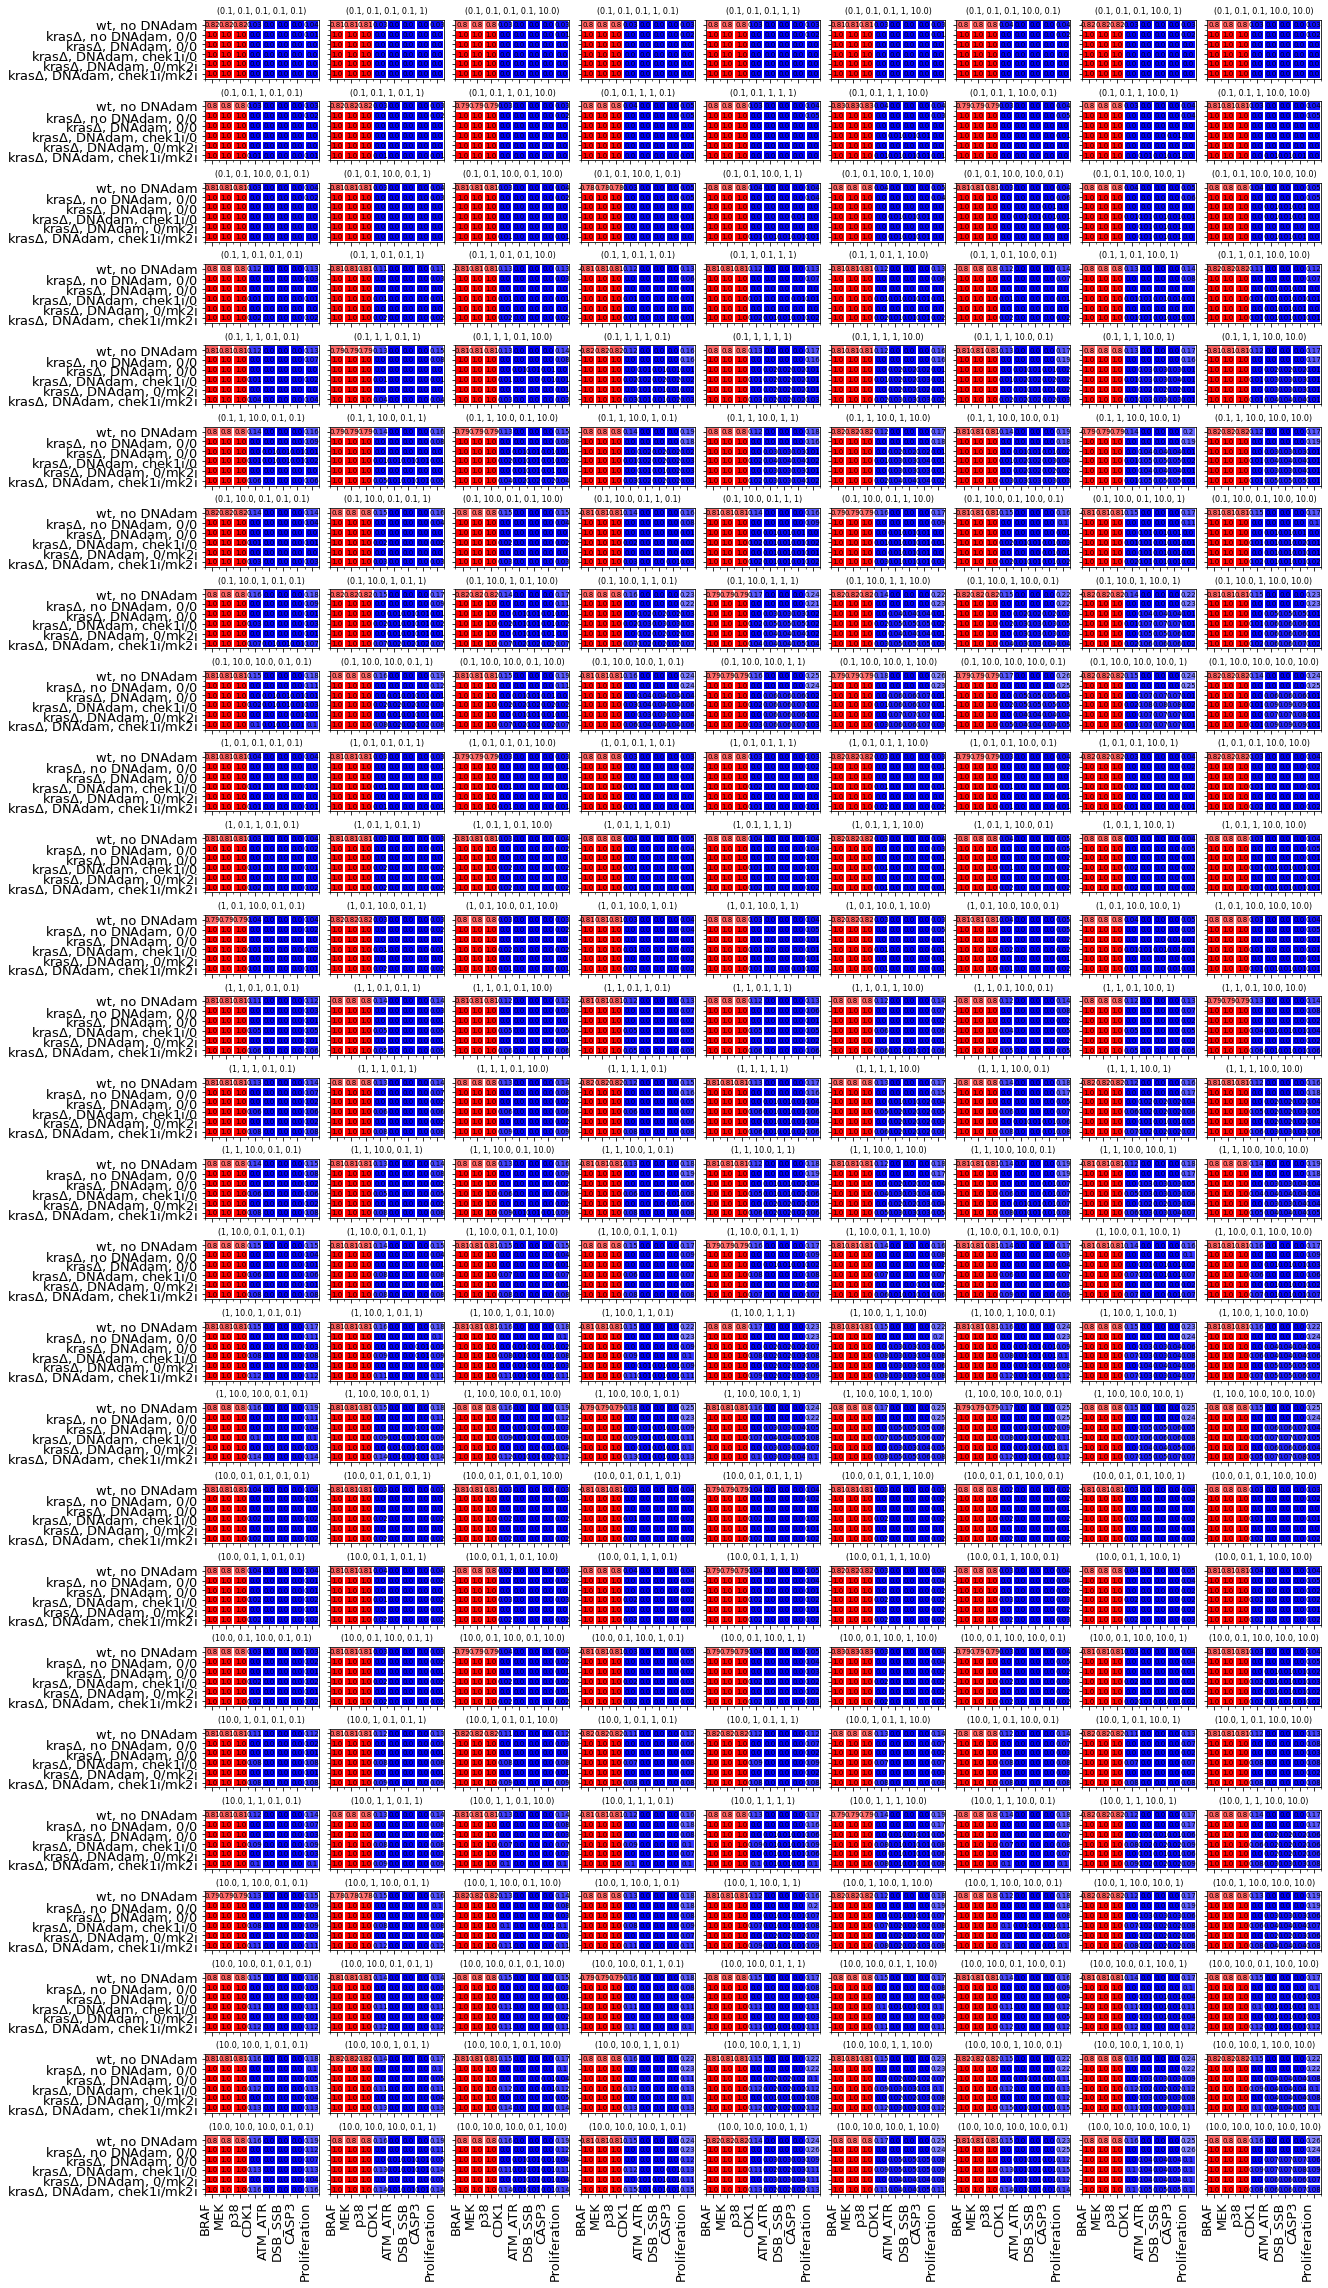

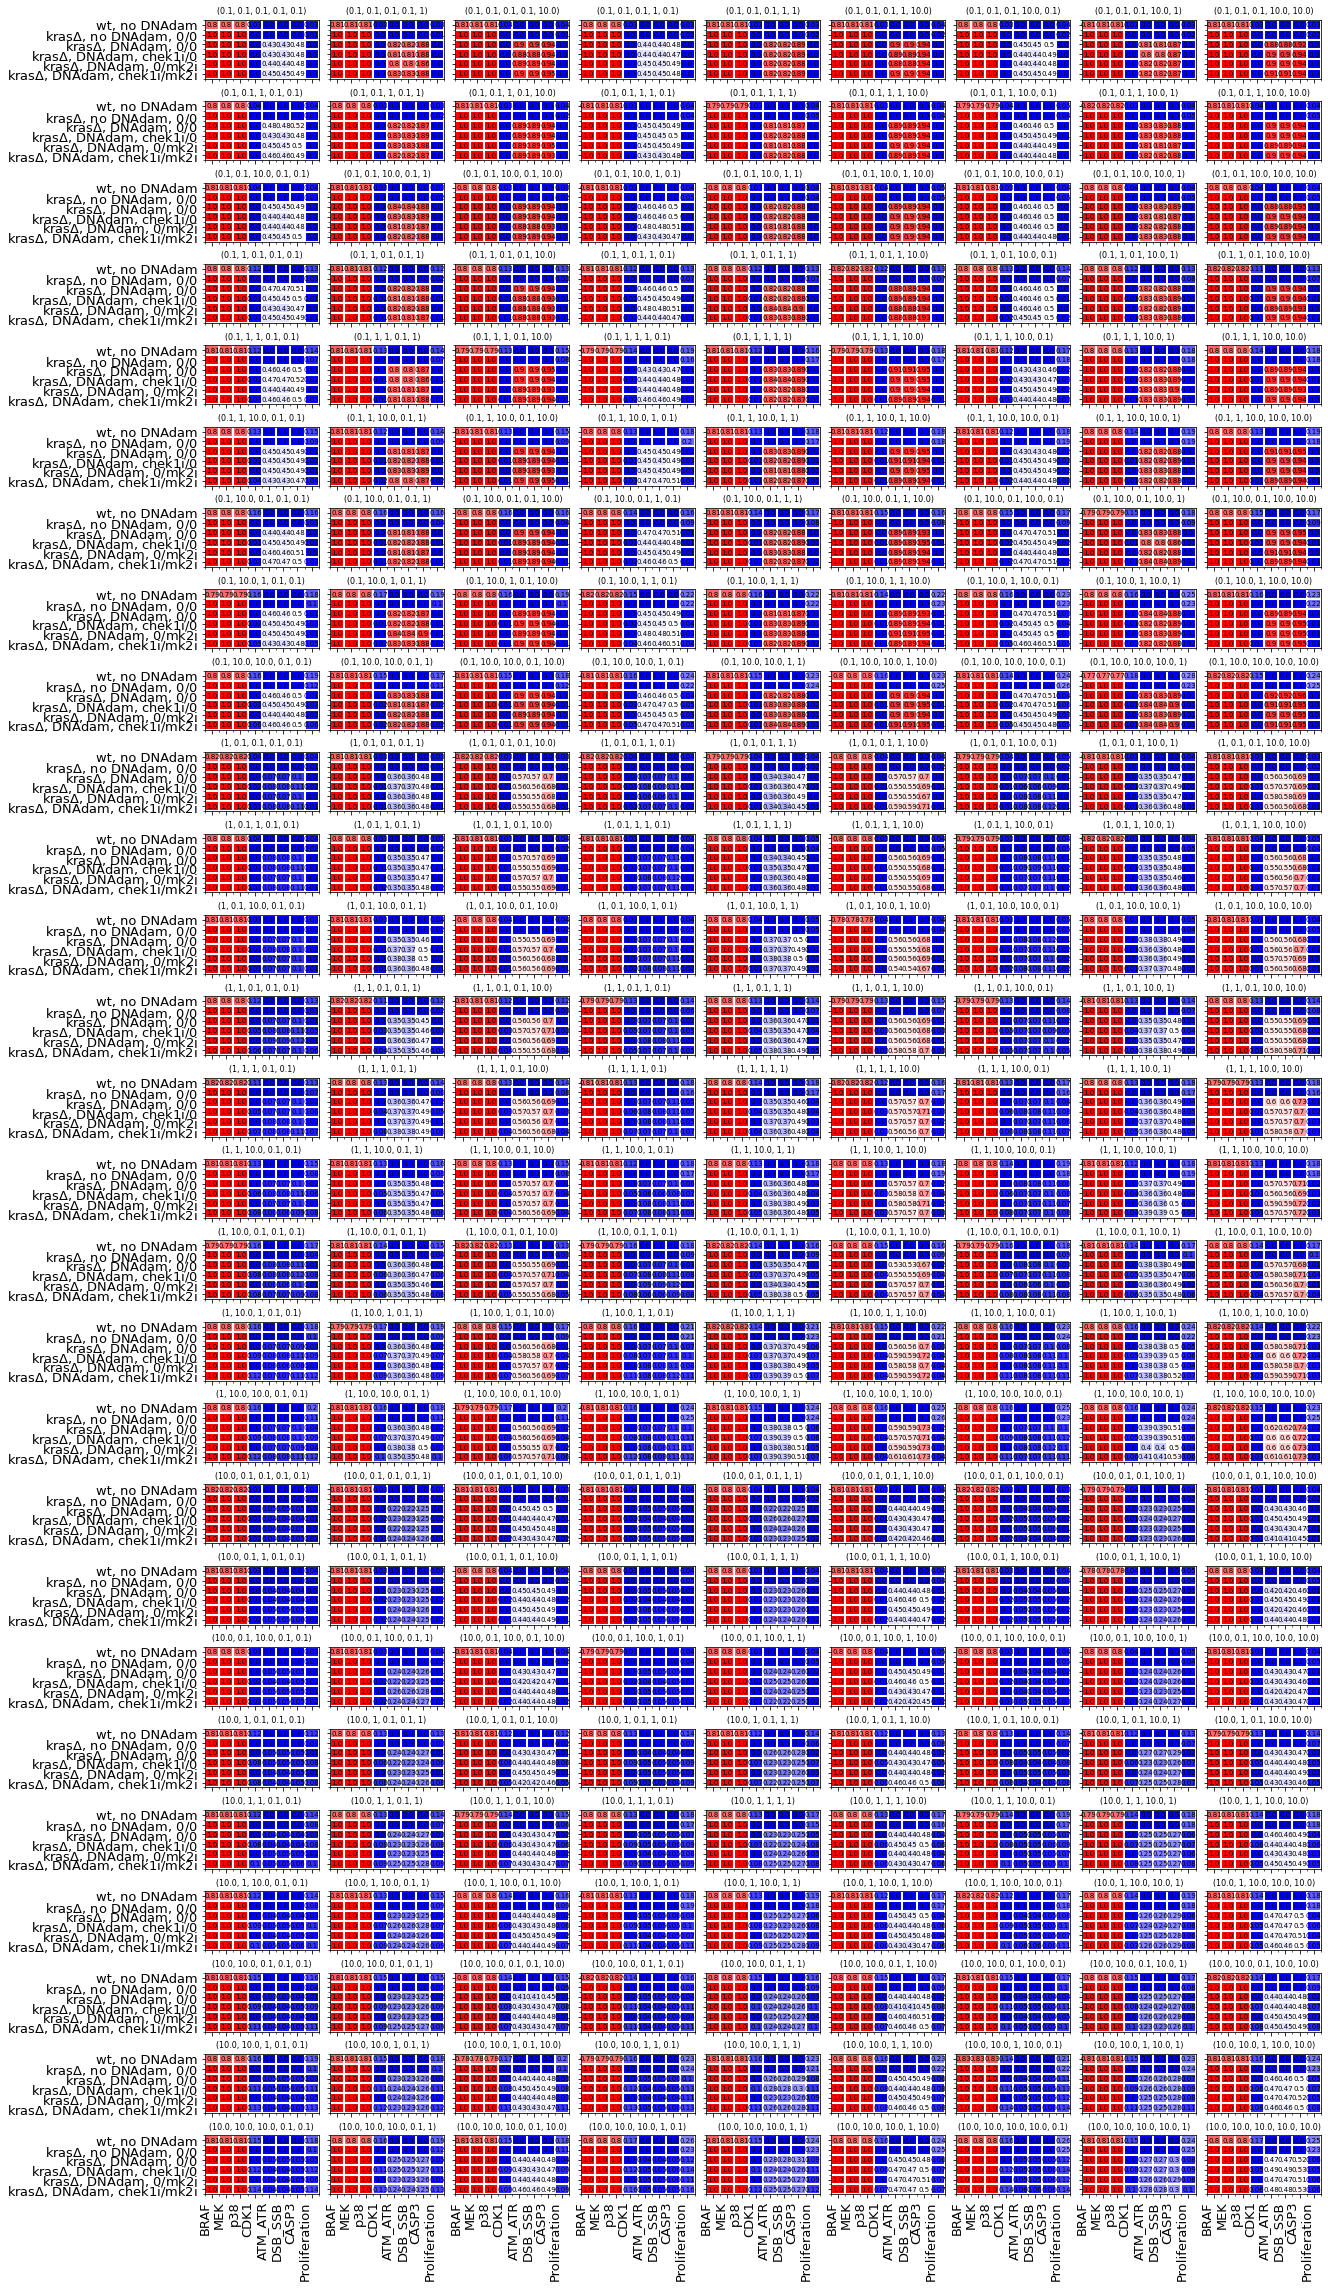

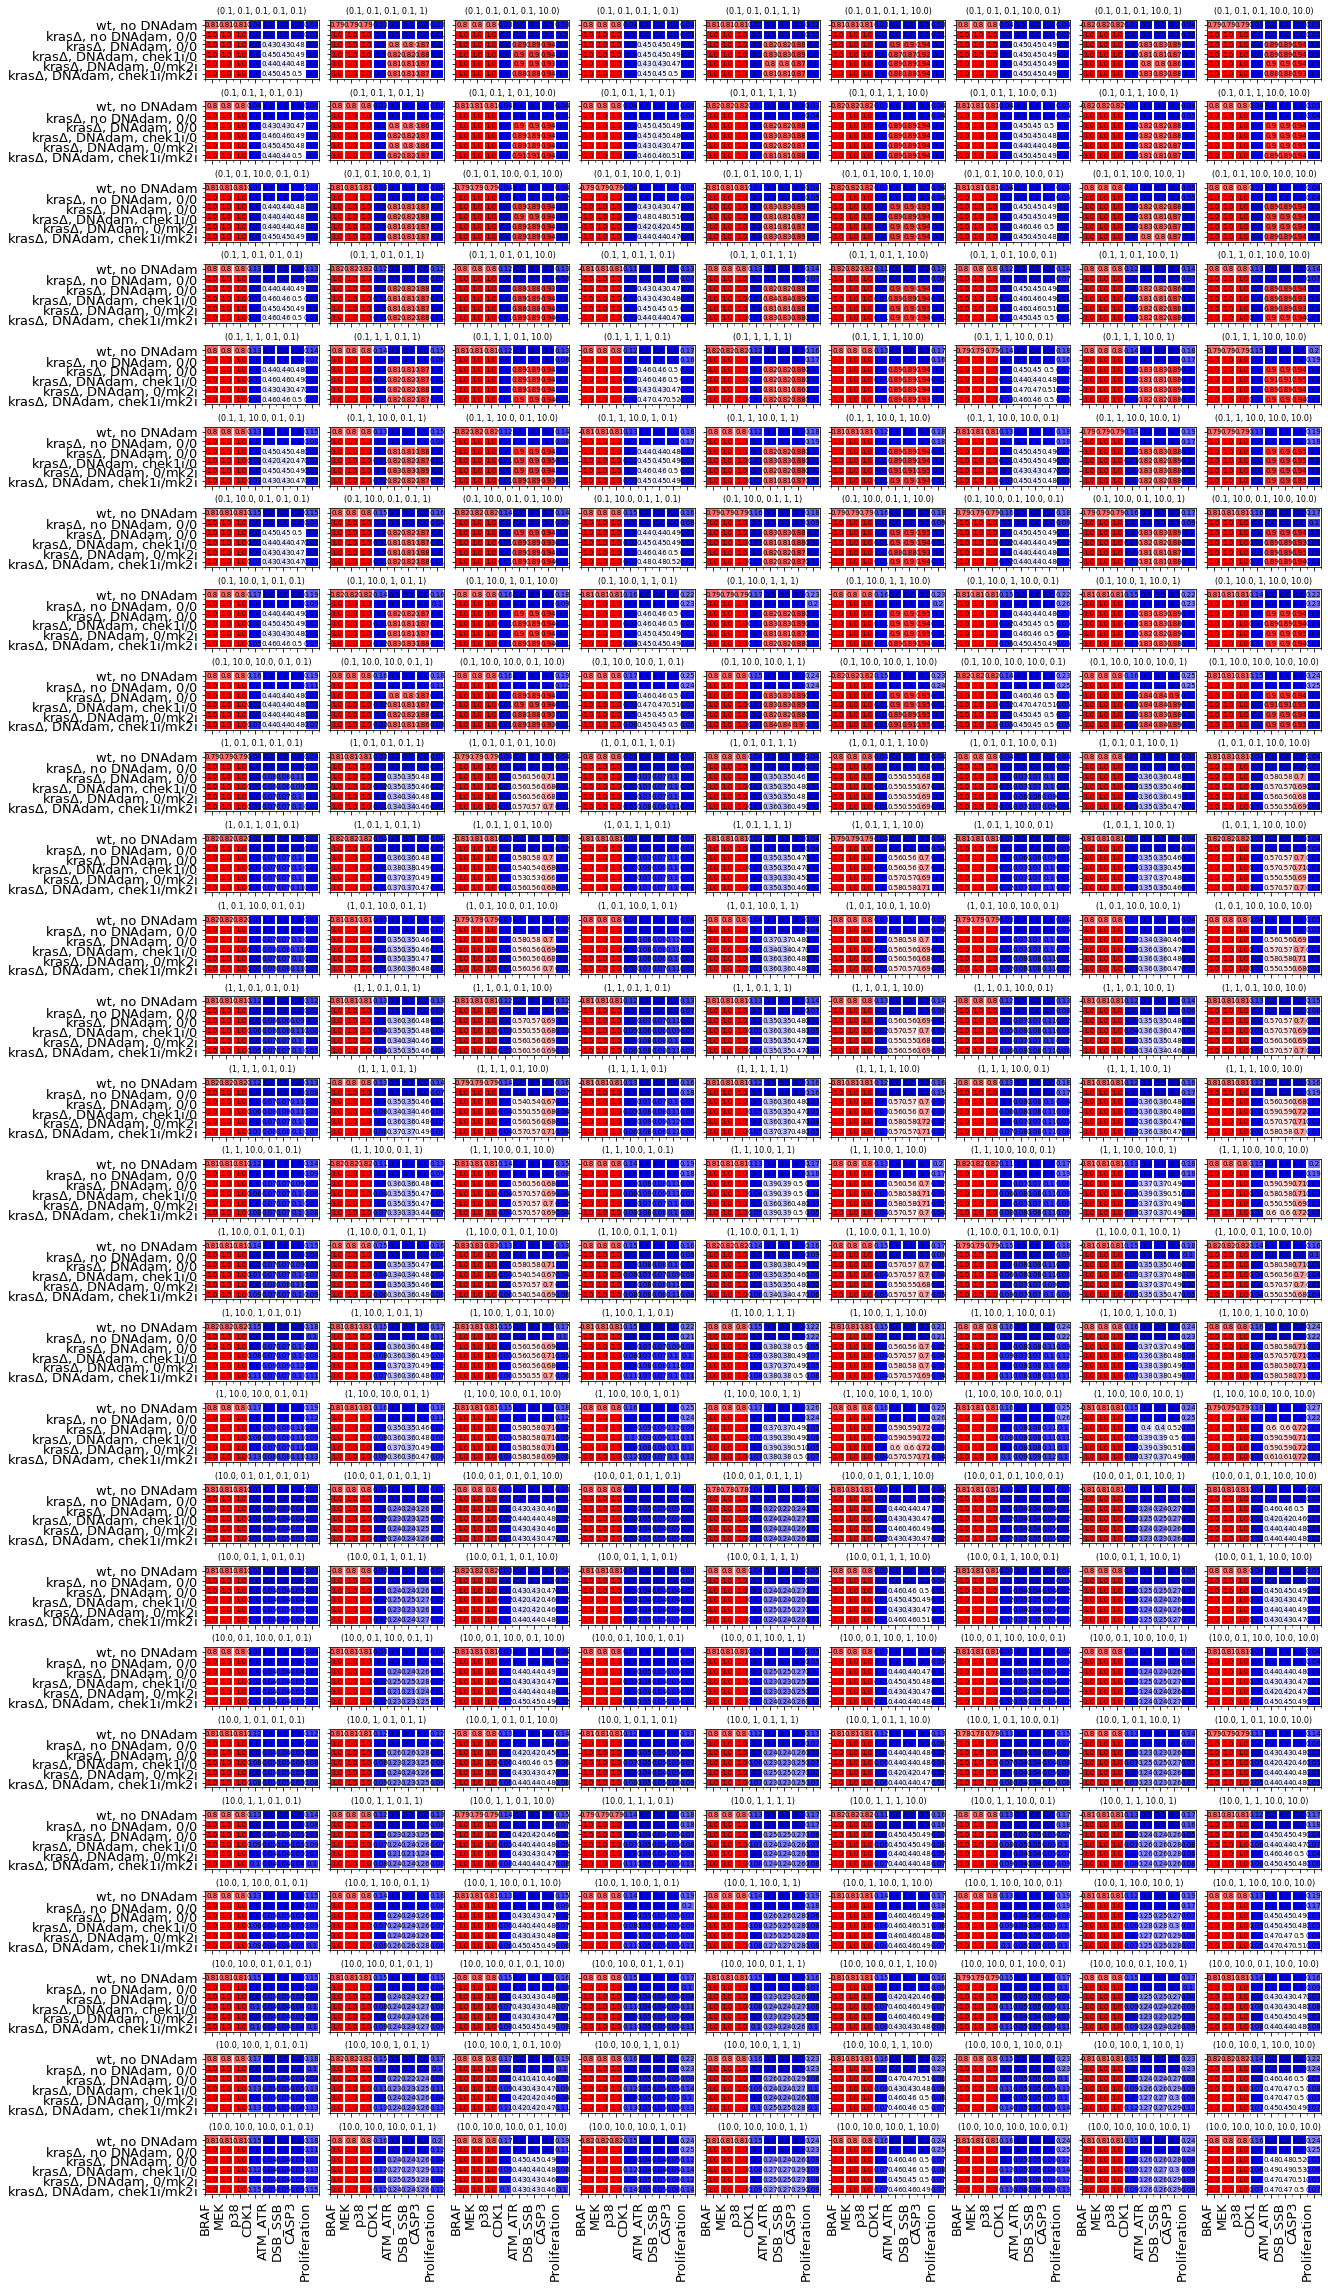

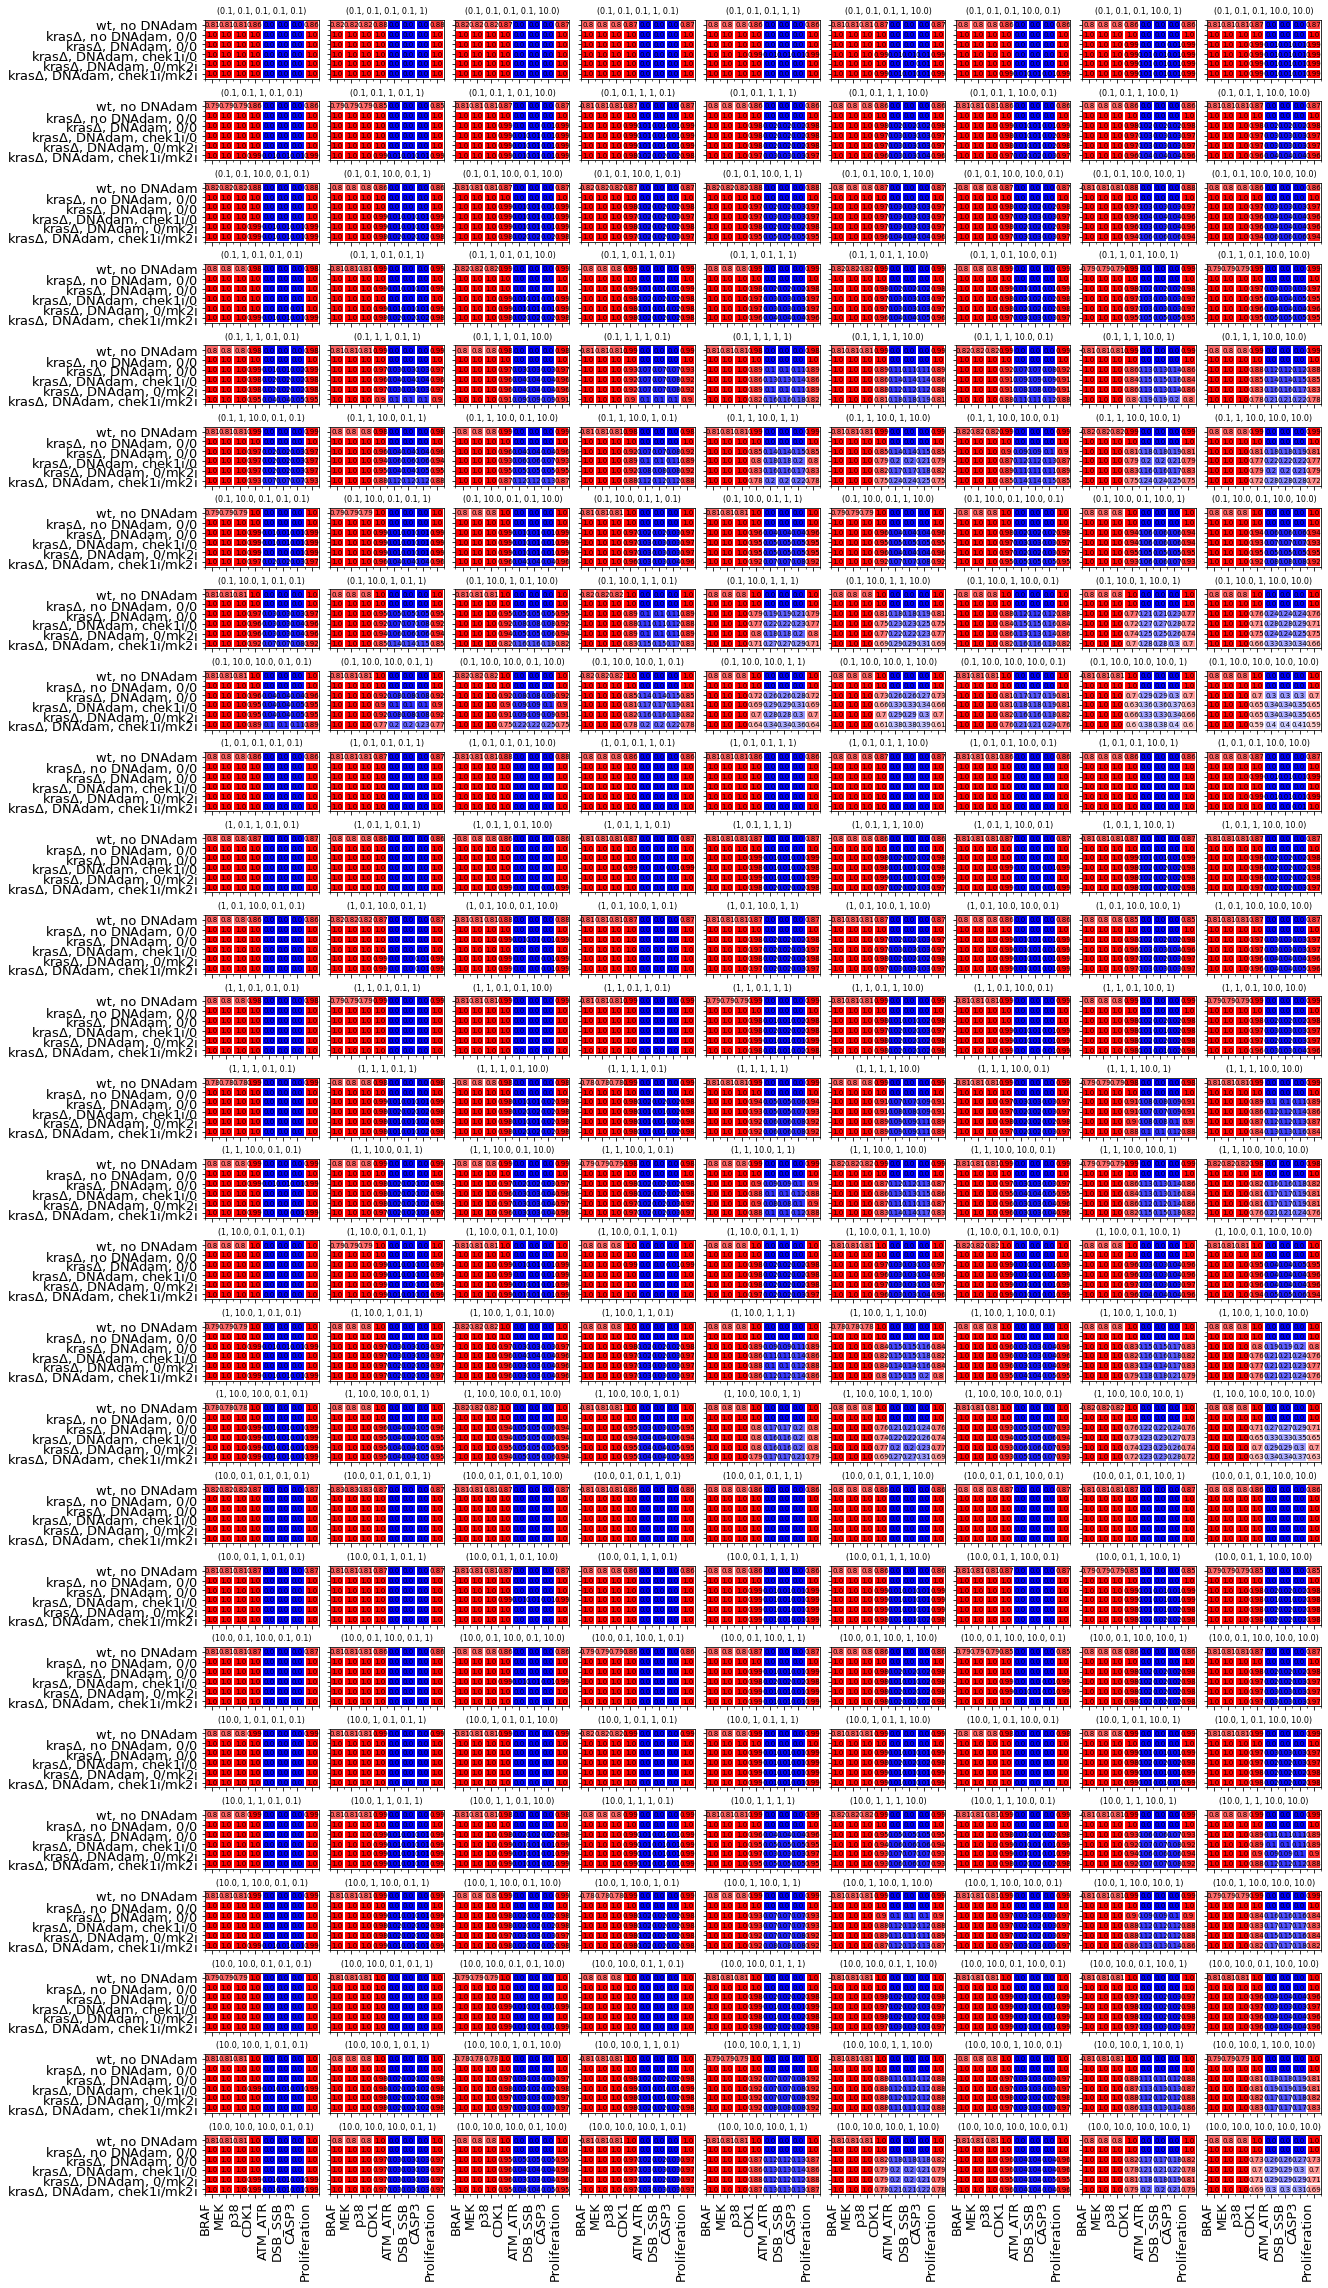

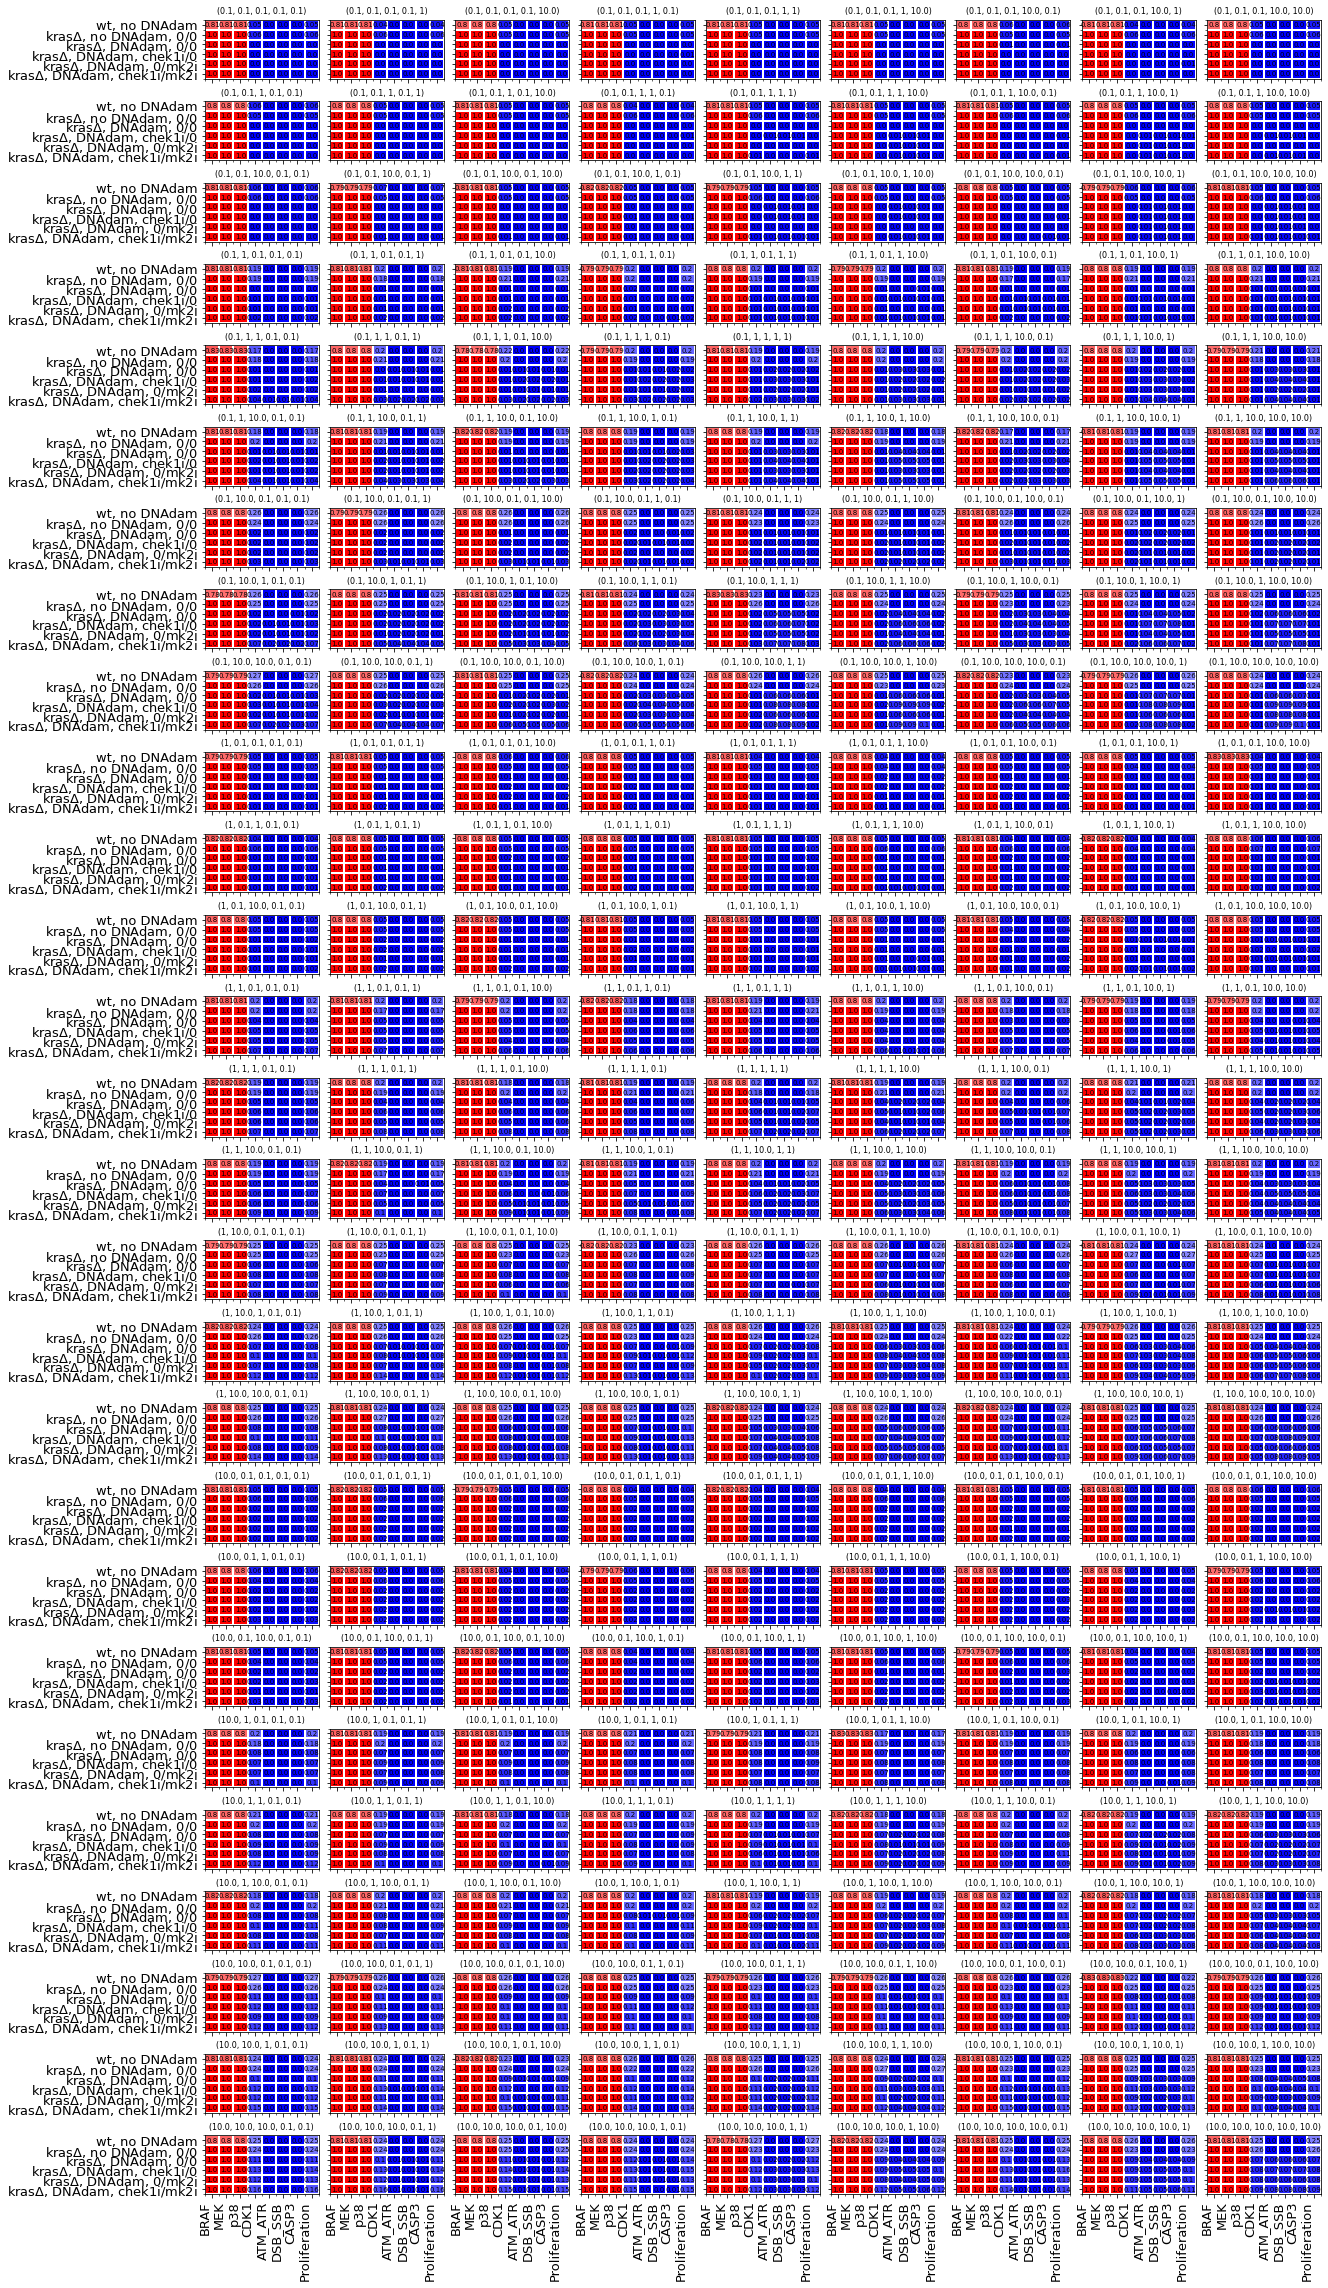

In [33]:
cbar_padding=0.03; title_fonts=20; 
from mpl_toolkits.axes_grid1 import make_axes_locatable
# fig.colorbar(pcm,ax=axs[0],fraction=0.045,pad=cbar_padding); plt.figure(figsize=(30,4))
colnum=int(9)
conds=pd_parscan_results_allmodels["conds"].unique()
sel_nodes=["BRAF","MEK","p38","CDK1","ATM_ATR","DSB_SSB","CASP3","Proliferation"]
subpl_dim=[int(np.ceil(len(parscan_results)/colnum)),colnum]
title_fonts=8 # cbar_padding=0.03; 
# fig.set_size_inches(20,20);  
modelnames=pd_parscan_results_allmodels["model"].unique()
for m in range(len(modelnames)): #  
    fig,axs=plt.subplots(subpl_dim[0],subpl_dim[1]) # gridspec_kw={'width_ratios':[1,1,1]}
    fig.set_size_inches(20,40); fig.subplots_adjust(wspace=0.1,hspace=0.38) # 
    for k in range(len(parscan_results)):
        # ax=fig.add_subplot(np.ceil(len(parscan_results)/colnum),colnum,k+1);
        ax=fig.add_subplot(axs[np.unravel_index([k],(subpl_dim[0],subpl_dim[1]))[0][0],\
                               np.unravel_index([k],(subpl_dim[0],subpl_dim[1]))[1][0]])
        truthvals=(pd_parscan_results_allmodels["parset"]==k)&\
            pd_parscan_results_allmodels["model"].str.contains(modelfiles[m])
        data=pd_parscan_results_allmodels[truthvals].iloc[:,3:][sel_nodes] # parscan_results[k][sel_nodes]
        
        pcm=ax.imshow(data.replace(np.nan,0),interpolation='none',cmap='bwr',vmin=0,vmax=1,aspect="auto")
        hmap_size=data.shape
        # ticks
        ax.set_xticks(np.arange(0,hmap_size[1],1)); ax.set_yticks(np.arange(0,hmap_size[0],1));
        # Minor ticks
        ax.set_xticks(np.arange(-0.5,hmap_size[1],1),minor=True);
        ax.set_yticks(np.arange(-0.5,hmap_size[0],1),minor=True)
        # Labels for major ticks
        ax.set_xticklabels([])
        if k>((axs.shape[0]-1)*colnum-1):ax.set_xticklabels(data.columns.values,rotation=90,fontsize=13,ha='right')
        if k % colnum==0: ax.set_yticklabels(barplot_titles,fontsize=13);
        else: ax.set_yticklabels([])
        # Gridlines based on minor ticks
        ax.grid(which='minor',color='w',linestyle='-',linewidth=2)
        # write values
        for (j,i),label in np.ndenumerate(data.replace(np.nan,0)):
            ax.text(i,j,np.round(label,2),ha='center',va='center',fontsize=7)
        # title
        ax.set_title(str(paramsets[k]),fontsize=title_fonts) # 
        # if k % colnum==2: plt.colorbar(pcm,ax=ax,fraction=0.045,pad=0.02) # pad=cbar_padding
    parscan_folder='figs/parscan_heatmaps/'+parscan_str+"/"
    if not os.path.isdir(parscan_folder):
        os.mkdir(parscan_folder)
    plt.savefig(parscan_folder+modelnames[m].replace('.bnet','')+'_'+parscan_str+".pdf",\
               bbox_inches='tight')


# Model validation

In [37]:
modelnames=pd_parscan_results_allmodels["model"].unique()
# condition for Proliferation: cond6<cond4<cond5<cond3, cond2>cond1

pd_cond_truth_columns=np.hstack(['model',params_str,\
                       'prolif(kras$\Delta$)>prolif(wt)',
                        'prolif(kras$\Delta$)>prolif(chk1i)',\
                       'prolif(kras$\Delta$)>prolif(mk2i)',
                        'prolif(chk1i)<prolif(mk2i)',\
                        'prolif(kras$\Delta$)>prolif(chk1i,mk2i)',\
                                'prolif(chk1i)>prolif(chk1i,mk2i)'])
pd_cond_truth=pd.DataFrame(columns=pd_cond_truth_columns); cntr=-1
for k in range(len(modelnames)):
    for l in range(len(pd_parscan_results_allmodels['parset'].unique())):
        truthvals=(pd_parscan_results_allmodels["parset"]==l)&\
            pd_parscan_results_allmodels["model"].str.contains(modelfiles[k])
        data=np.round(pd_parscan_results_allmodels[truthvals],3)
        # dnadam, chek1inhib, mk2inhib, doubleinhib
        prolif_score=np.hstack((k,[f for f in paramsets[l]],\
                    data['Proliferation'][2]>data['Proliferation'][1],\
                    data['Proliferation'][3]<data['Proliferation'][2],\
                    data['Proliferation'][4]<data['Proliferation'][2],\
                    data['Proliferation'][4]>data['Proliferation'][3],\
                    data['Proliferation'][5]<data['Proliferation'][2],\
                    data['Proliferation'][5]<data['Proliferation'][3] ))
        cntr=cntr+1; pd_cond_truth.loc[cntr]=prolif_score
        # pd_parscan_results_allmodels[truthvals].iloc[:,3:][sel_nodes]

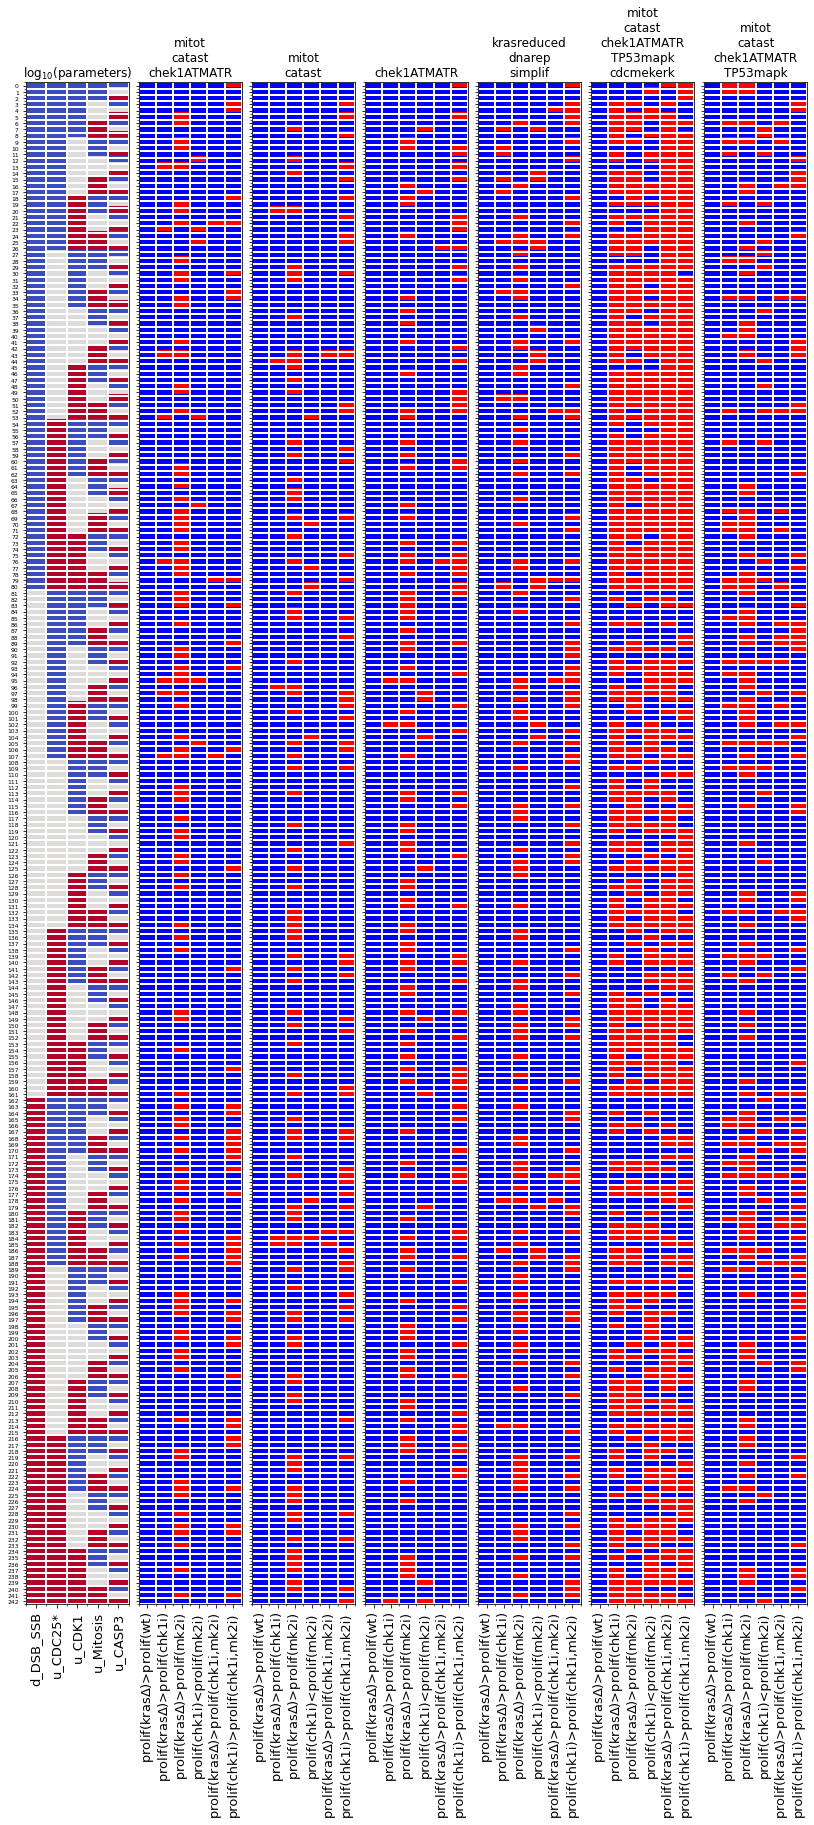

In [58]:
# fig=plt.figure(); fig.set_size_inches(10,10)
# plt.imshow(pd_cond_truth.iloc[:,4:],interpolation='none',cmap='bwr')
# pd_cond_truth
modelnames=pd_parscan_results_allmodels["model"].unique()

fig,axs=plt.subplots(1,len(modelnames)+1) # gridspec_kw={'width_ratios':[1,1,1]}
fig.set_size_inches(14,28); fig.subplots_adjust(wspace=0.1) # ,hspace=0.08 
for k in range(len(modelnames)+1):
    ax=fig.add_subplot(axs[k]); col_lim=len(params_str)+1
    if k==0:
        dataplot=np.log10(pd_cond_truth.iloc[np.flatnonzero(pd_cond_truth["model"]==k),1:col_lim]); 
        cmapval='coolwarm'
    else:
        dataplot=pd_cond_truth.iloc[np.flatnonzero(pd_cond_truth["model"]==k-1),col_lim:].astype('bool'); 
        cmapval='bwr'
    hmapd=dataplot.shape
    pcm=ax.imshow(dataplot,interpolation='none',cmap=cmapval,aspect="auto")
    # ticks
    ax.set_xticks(np.arange(0,hmapd[1],1)); ax.set_yticks(np.arange(0,hmapd[0],1));
    # Minor ticks
    ax.set_xticks(np.arange(-0.5,hmapd[1],1),minor=True); ax.set_yticks(np.arange(-0.5,hmapd[0],1),minor=True)
    # Labels for major ticks
    ax.set_xticklabels(dataplot.columns.values,rotation=90,fontsize=13) # ,ha='right'
    if k>0: titlestr=[x.replace('.bnet','') \
                      for x in modelfiles][k-1].replace('krasreduced_dnarep_simplif_','').replace('_','\n')
    else: titlestr='log$_{10}$(parameters)'
    ax.set_title(titlestr)
    
    if k==0: ax.set_yticklabels(range(len(paramsets)),fontsize=6)
    #    for (j,i),label in np.ndenumerate(dataplot):
    #        ax.text(i,j,np.round(label,2),ha='center',va='center',fontsize=9,color='lime')
    else: ax.set_yticklabels([]) # ax.set_yticklabels(barplot_titles,fontsize=13);
    # Gridlines based on minor ticks
    ax.grid(which='minor',color='w',linestyle='-',linewidth=2)
plt.savefig('figs/parscan_heatmaps/'+parscan_str+'/models_conds_satisf.pdf',bbox_inches='tight')

In [57]:
parscan_str

'243parsets'

## Radar chart

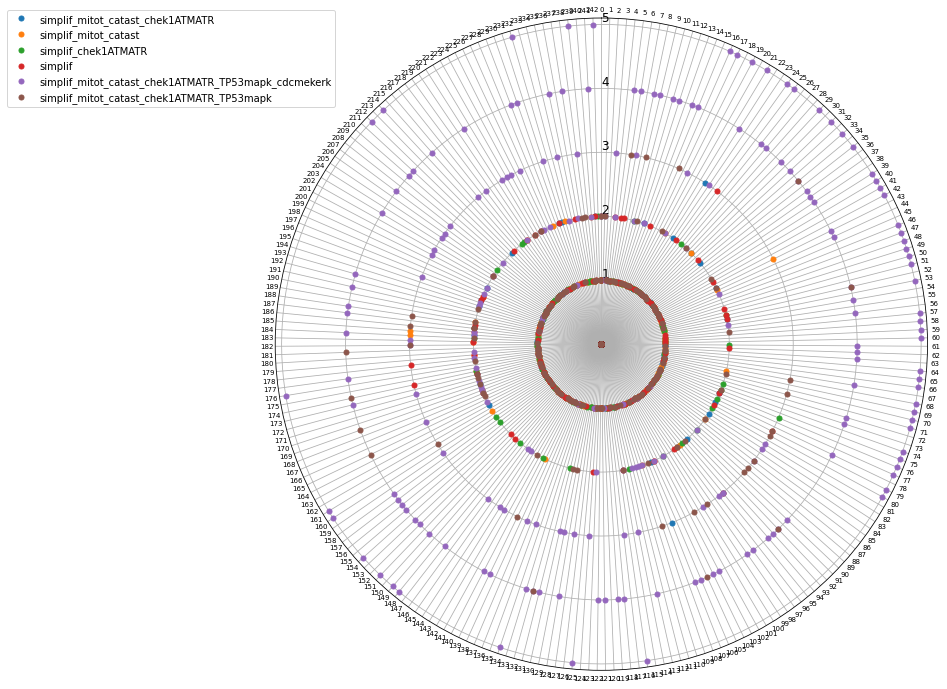

In [238]:
# markervals=["o","^","*","s","p","h"]; fig=plt.figure(); fig.set_size_inches(20,6)
# prolifcolstart=np.flatnonzero(['prolif' in f for f in pd_cond_truth.columns.values])[0]
# for k in range(len(modelfiles)):
#     dataplot=pd_cond_truth.iloc[np.flatnonzero(pd_cond_truth["model"]==k),prolifcolstart:]
#     ax=plt.plot(range(len(paramsets)),np.sum(dataplot,axis=1),marker=markervals[k],\
#             linestyle='',label=modelnames[k],markersize=5)
# plt.xlim([-1,len(paramsets)+1]); plt.grid('minor'); 
# plt.xticks(range(len(paramsets)),rotation=90,fontsize=6)
# plt.xlabel('parameter set',fontsize=14); plt.ylabel('score',fontsize=14); 
# plt.legend(bbox_to_anchor=(0.03,1.02))
# plt.savefig('figs/parscan_heatmaps/'+parscan_str+'/modelscores.pdf',bbox_inches='tight')

from math import pi
# 'A',np.sum(dataplot,axis=1)
index_str=[m.replace('.bnet','').replace('krasreduced_dnarep_','') for m in modelfiles]
df_score=pd.DataFrame(index=index_str,columns=range(len(paramsets)))
for k in range(len(modelfiles)):
    dataplot=pd_cond_truth.iloc[np.flatnonzero(pd_cond_truth["model"]==k),prolifcolstart:]; 
    df_score.iloc[k,:]=np.sum(dataplot,axis=1).values
df_score.reset_index(inplace=True); df_score.columns.values[0]='group'
#
N=len(paramsets)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N)*2*pi for n in range(N)]; angles += angles[:1]
# Initialise the spider plot
fig=plt.figure(); ax=plt.subplot(111, polar=True); fig.set_size_inches(12,12)
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2); ax.set_theta_direction(-1)
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], range(len(paramsets)),size=7,rotation=90); ax.tick_params(axis='x',pad=-2)
# Draw ylabels
ax.set_rlabel_position(0); plt.yticks([1,2,3,4,5], ["1","2","3","4",'5'],color="black",size=12); plt.ylim(0,5.1)

for k in range(len(modelfiles)):
    values=df_score.loc[k].drop('group').values.flatten().tolist()
    values+=values[:1]
    label_str=modelfiles[k].replace('.bnet','').replace('krasreduced_dnarep_','')
    ax.plot(angles, values,linestyle='',marker='o',markersize=5,label=label_str)
    # ax.fill(angles, values, 'b', alpha=0.1)
plt.legend(bbox_to_anchor=(0.1,1.02))
plt.savefig('figs/parscan_heatmaps/'+parscan_str+'/modelscores_radarplot.pdf',bbox_inches='tight')

# Dynamics

In [213]:
# filename=modelnames[2]; WT=maboss.loadBNet(filename); 
# WT.param["max_time"]=100; WT.param['time_tick']=0.5; WT.param['sample_count']=3e3
# WT.network.set_istate('EGFR',[0,1]); WT.network.set_istate('DNArepair',[1,0])
# WT.network.set_istate('DSB_SSB',[1,0]); WT.network.set_istate('RAS',[1,0])
# params_str_nested=['d_DSB_SSB',['u_CDC25A','u_CDC25B_C'],'u_CDK1','u_Mitosis'];

def fcn_wt_krasmut_4conds(WT,params_str_nested,paramsets,n_par):
        for k in range(len(params_str_nested)):
            if np.size(params_str_nested[k])==1: WT.param["$"+params_str_nested[k]]=paramsets[n_par][k];
            else: 
                for l in range(len(params_str_nested[k])): 
                    WT.param["$"+params_str_nested[k][l]]=paramsets[n_par][k] 
        # set initconds
        WT_run=WT.run()
        #############
        # KRASmut no DNA damage
        krasmut=maboss.copy_and_mutate(WT,["RAS"],"ON"); krasmut_run=krasmut.run()
        #############
        # KRASmut DNA damage
        krasmut_dnadam=maboss.copy_and_mutate(WT,["RAS"],"ON"); 
        krasmut_dnadam.network.set_istate('DSB_SSB',[0,1])
        krasmut_dnadam_run=krasmut_dnadam.run()
        #############
        # KRASmut DNAdam + CHEK1off
        krasmut_dnadam_chek1off=maboss.copy_and_mutate(WT,["RAS"],"ON");
        krasmut_dnadam_chek1off.mutate("CHEK1","OFF")
        krasmut_dnadam_chek1off.network.set_istate('DSB_SSB',[0,1]);
        krasmut_dnadam_chek1off.network.set_istate('RAS',[0,1])
        krasmut_dnadam_chek1off_run=krasmut_dnadam_chek1off.run()
        #############
        # KRASMUT + DNADAM + MK2off
        krasmut_dnadam_mk2off=maboss.copy_and_mutate(WT,["RAS"],"ON"); krasmut_dnadam_mk2off.mutate("MK2","OFF")
        krasmut_dnadam_mk2off.network.set_istate('DSB_SSB',[0,1]);
        krasmut_dnadam_mk2off.network.set_istate('RAS',[0,1])
        krasmut_dnadam_mk2off_run=krasmut_dnadam_mk2off.run()
        #############
        # KRASMUT + DNADAM + CHEK1off + MK2off
        krasmut_dnadam_chek1mk2off=maboss.copy_and_mutate(WT, ["RAS"], "ON"); 
        krasmut_dnadam_chek1mk2off.mutate("MK2","OFF"); krasmut_dnadam_chek1mk2off.mutate("CHEK1","OFF")
        krasmut_dnadam_chek1mk2off.network.set_istate('DSB_SSB',[0,1]);
        krasmut_dnadam_chek1mk2off.network.set_istate('RAS',[0,1])
        krasmut_dnadam_chek1mk2off_run=krasmut_dnadam_chek1mk2off.run()
        return WT_run,krasmut_run,krasmut_dnadam_run,krasmut_dnadam_chek1off_run,\
                krasmut_dnadam_mk2off_run,krasmut_dnadam_chek1mk2off_run

In [226]:
pd_parscan_results_allmodels.iloc[np.flatnonzero(pd_parscan_results_allmodels)]

conds  parset  \
0                   wt, no DNAdam       0   
1    kras$\Delta$, no DNAdam, 0/0       0   
2       kras$\Delta$, DNAdam, 0/0       0   
3  kras$\Delta$, DNAdam, chek1i/0       0   
4    kras$\Delta$, DNAdam, 0/mk2i       0   

                                               model  ATM_ATR   BRAF   CASP3  \
0  krasreduced_dnarep_simplif_mitot_catast_chek1A...      NaN  0.803     NaN   
1  krasreduced_dnarep_simplif_mitot_catast_chek1A...      NaN  1.000     NaN   
2  krasreduced_dnarep_simplif_mitot_catast_chek1A...      NaN  1.000     NaN   
3  krasreduced_dnarep_simplif_mitot_catast_chek1A...   0.0005  1.000  0.0005   
4  krasreduced_dnarep_simplif_mitot_catast_chek1A...      NaN  1.000     NaN   

   CDC25A  CDC25B_C    CDK1  CHEK1   CHEK2  DSB_SSB    EGFR    MEK     MK2  \
0  0.0325    0.0325  0.0325  0.803     NaN      NaN  0.8030  0.803     NaN   
1     NaN       NaN     NaN  1.000     NaN      NaN  0.7995  1.000     NaN   
2     NaN       NaN     NaN  1.000     NaN      NaN  0.8595  1.000     NaN   
3  0.0035    0.0035  0.0035    NaN  0.0005   0.0005  0.8515  1.000  0.0005   
4     NaN       NaN     NaN  1.000     NaN      NaN  0.8700  1.000     NaN   

   Mitosis  Proliferation    RAS    TP53    p38  
0   0.0325         0.0325  0.803     NaN  0.803  
1   0.0065         0.0065  1.000     NaN  1.000  
2      NaN            NaN  1.000     NaN  1.000  
3   0.0045         0.0040  1.000  0.0005  1.000  
4   0.0010         0.0010  1.000     NaN  1.000

In [239]:
# filename='krasreduced_dnarep_simplif_mitot_catast_chek1ATMATR_TP53mapk_cdcmekerk.bnet';
# fig,axs=plt.subplots(3,2,figsize=(20,15)); plt.suptitle(filename,fontsize=15)

n_mod=4; filename=modelnames[n_mod]; WT=maboss.loadBNet("model_ens/"+filename); 
WT.param["max_time"]=100; WT.param['time_tick']=0.5; WT.param['sample_count']=3e3
WT.network.set_istate('EGFR',[0,1]); WT.network.set_istate('DNArepair',[1,0])
WT.network.set_istate('DSB_SSB',[1,0]); WT.network.set_istate('RAS',[1,0])

params_str_nested=['d_DSB_SSB',['u_CDC25A','u_CDC25B_C'],'u_CDK1','u_Mitosis'];
n_par=79
# RUN SIMUL
simul_results=fcn_wt_krasmut_4conds(WT,params_str_nested,paramsets,n_par)


(0.1, 10.0, 10.0, 10.0, 1)

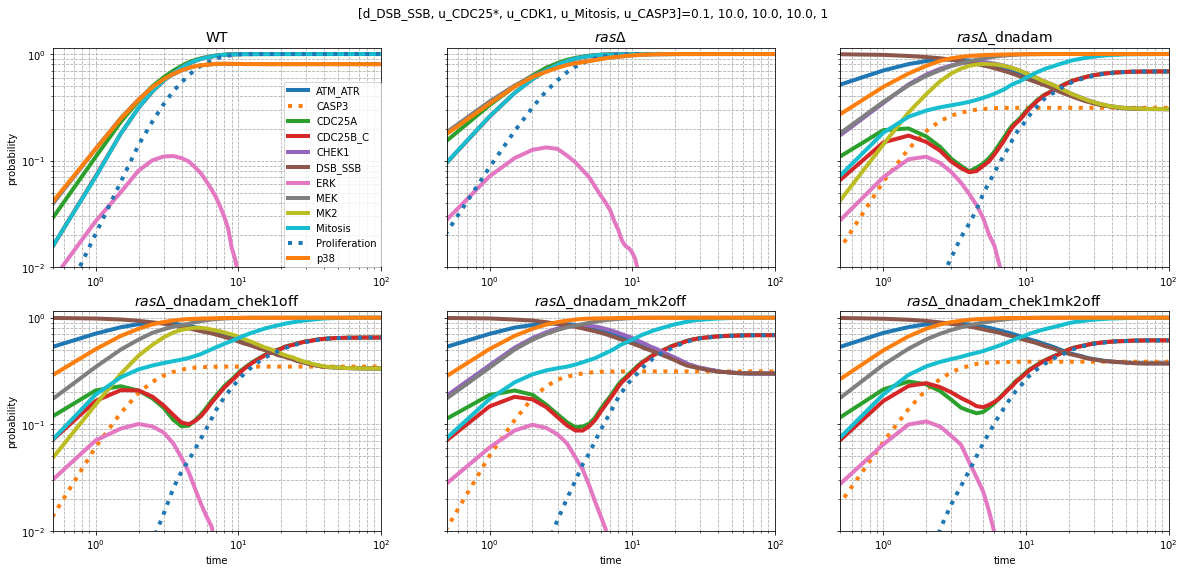

In [295]:
fig=plt.figure(); fig.set_size_inches(20,38);  
fig_pars=[4,8,6,'time', 'probability',50]
conds=['WT','$ras\Delta$','$ras\Delta$_dnadam','$ras\Delta$_dnadam_chek1off',\
       '$ras\Delta$_dnadam_mk2off','$ras\Delta$_dnadam_chek1mk2off']
nodes_string=['ATM_ATR','DSB_SSB','MEK','ERK','MK2','CHEK1','CDC','Mitosis','p38','Proliferation','CASP3']
for subpl_cntr in range(len(simul_results)):
    ax1=fig.add_subplot(8,len(conds)/2,subpl_cntr+1);
    maboss_results_object=simul_results[subpl_cntr]
    nodes_probtraj_df=pd.DataFrame(maboss_results_object.get_nodes_probtraj())
    col_inds=nodes_probtraj_df.columns.str.contains('|'.join(nodes_string),case=False)
    nodes_probtraj_df=nodes_probtraj_df.loc[:,col_inds]
    for k in range(nodes_probtraj_df.shape[1]):
        varname=nodes_probtraj_df.columns[k]; lnst_val='-'
        if varname in ['Proliferation','CASP3']: lnst_val='dotted'
        ax1.plot(nodes_probtraj_df.iloc[:,k],linewidth=fig_pars[0],label=varname,linestyle=lnst_val) 
        if (subpl_cntr+1) % len(conds)==1: plt.legend(borderaxespad=0,loc='best') # ,ncol=2
    plt.xlim([0.5,1e2]); plt.ylim([0.01,1.15]); 
    plt.xscale('log'); plt.yscale('log'); plt.grid(True, which="both",linestyle='--'); 
    plt.title(conds[subpl_cntr],fontsize=14);
    if (subpl_cntr+1) % (len(conds)/2)==1: plt.ylabel(fig_pars[4]); 
    else: ax1.set_yticklabels([]);
    if subpl_cntr>(len(conds)/2-1): plt.xlabel(fig_pars[3]); 
    # if len(fig_pars)>5: plt.xlim(0,fig_pars[5])
pset=paramsets[n_par]
plt.suptitle('['+', '.join(params_str)+']='+', '.join([str(p) for p in pset]),y=0.895);
plt.savefig('figs/parscan_heatmaps/'+parscan_str+'/dynamics_model'+str(n_mod)+'_parset'+str(n_par)+'.pdf',\
            bbox_inches='tight')

In [296]:
n_par=79; n_model=4;
truthvals=(pd_parscan_results_allmodels["parset"]==n_par)&\
            pd_parscan_results_allmodels["model"].str.contains(modelfiles[n_model])

pd_parscan_results_allmodels.loc[truthvals,['conds','Proliferation','CASP3']]



conds  Proliferation   CASP3
0                      wt, no DNAdam         1.0000     NaN
1       kras$\Delta$, no DNAdam, 0/0         1.0000     NaN
2          kras$\Delta$, DNAdam, 0/0         0.6960  0.3040
3     kras$\Delta$, DNAdam, chek1i/0         0.6295  0.3705
4       kras$\Delta$, DNAdam, 0/mk2i         0.6610  0.3390
5  kras$\Delta$, DNAdam, chek1i/mk2i         0.6035  0.3965